# ECG EDA PTBXL

In this notebook, we analyze the ECG records, both the signals and the diagnoses, to get a clear understanding on how to best preprocess the data. We will focus on the PTB-XL dataset, as it has a wide range of diagnoses, a large number of records, and some additional information since this DB exists both for the Physionet Challenge and as its own, and each contains valueable insight to work on the preprocessing.

Verify usage of GPU. If Num GPUs Available is 0, consider enabling at least one. Otherwise, the models take too long to fit.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Import modules.

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Python waveform-database (WFDB) package
import wfdb
from wfdb import processing

# Visualization
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import seaborn as sns

# scipy
from scipy.ndimage import median_filter
from scipy.stats import iqr

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

# Tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Reshape
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.layers import concatenate 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1 

from tensorflow.keras.layers import Conv1DTranspose
import tensorflow_addons as tfa


# # PyTorch
# from torch import nn
# #!pip install torchsummary
# from torchsummary import summary

# Other
import os
import random
from loess.loess_1d import loess_1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import pickle
import re
import time
import json
import colorsys

# User defined
import scripts.ecg as ecg

# Downloaded scripts
from scripts.antonior92 import get_model

# Allow user defined modules to be dinamically updated
%load_ext autoreload
%autoreload 2

## Initial exploration

### First ECG Example

We will first visualize the data we are working with. We get the file names where the *.mat* files are contained, which contain the signals and the metadata for each electrocardiogram (ECG).

In [3]:
current_db = 'PTB-XL'
path = f'data/{current_db}/'
files = os.listdir(path)
hea_files = [file[:-4] for file in files if 'hea' in file]

We also load the SNOMED CT Code labels, in order to translate between the code number (f.ex. 270492004) and its corresponding diagnosis (f.ex. 1st degree av block).

In [4]:
labels = ecg.load_labels('data/')
labels.index = labels.index.astype(float).astype(int)
labels.iloc[:5, :2]

c:\users\mike\appdata\local\programs\python\python39\lib\site-packages\pandas\core\dtypes\cast.py:1097: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)


Diagnostic Description Abbreviation
SNOMED CT Code                                                 
270492004                      1st degree av block         IAVB
164889003                      atrial fibrillation           AF
164890007                           atrial flutter          AFL
426627000                              bradycardia        Brady
713427006       complete right bundle branch block        CRBBB

We will use this variable later on, so we define now for convenience.

In [5]:
requirements = {'path' : path, 'hea_files' : hea_files, 'imgs_path' : ecg.imgs_path,
                'current_db' : current_db, 'labels' : labels}

This is an example of the data we will be working with. We have 12 signals for each ECG, corresponding to different parts and combinations where certain nodes were placed in the body.
(image source: https://www.primemedicaltraining.com/12-lead-ecg-placement/).

This is an example of a standard ECG, without any complications, as denoted by the *sinus rhythm* diagnosis (*dx*).

![alternatvie text](imgs/nb/12-lead-ecg-vectors.png)

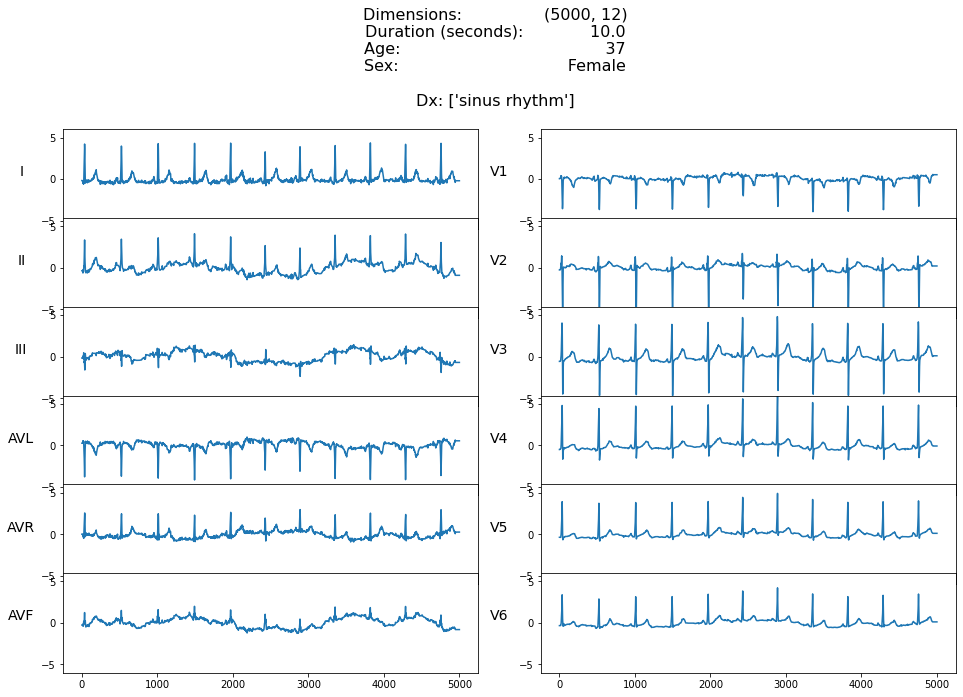

In [6]:
k = 2
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
ecg.plot_ecg(example[0], metadata=metadata)

### Retrieve All the Data

To make analyses based on all the data, we retrieve the signal and the metadata for each file.

In *X*, we store the 12-signal ECG for each register.

In *M*, we store the metadata of each register. The metadata contains the values of the age, sex, signal frequency, etc. Most importantly, it contains the diagnosis (dx) of the patient, which is the target variable if we want to use the SNOMED CT Code approach.

At first, we need to get the data from the `.hea` and `.mat` files. However, doing this every time we open the notebook takes a lor of time. To avoid this, we stored the data in more convinient and efficient formats. We will leave the cell commented on how we retrieved the data first just for any future usage of it to load other new files.

In [7]:
### In this cell, we loaded each individual file to get the ECG signals (X)
### and the metadata (M). This took around 10 minutes.

# files_to_load = [path + file for file in hea_files[0 : 21837]]
# X, M = ecg.load_data(files_to_load)
# np.save(path + 'X_1_21837', X)
# M.to_csv(path + 'M.csv')

Load the data from the previously stored files.

In [8]:
X_name = 'X_1_21837.npy'
M_name = 'M.csv'

X, M = ecg.load_X_and_M(path, X_name, M_name)

Get some insight of what we just retrieved.

In [9]:
print(X.shape)
print(M.shape)

(21837, 5000, 12)
(21837, 11)


The metadata dataframe looks as follows:

In [10]:
M.head()

age     sex                   dx       rx       hx       sx   fs  sig_len  \
0  56.0  Female  251146004,426783006  Unknown  Unknown  Unknown  500     5000   
1  19.0    Male  426177001,426783006  Unknown  Unknown  Unknown  500     5000   
2  37.0  Female            426783006  Unknown  Unknown  Unknown  500     5000   
3  24.0    Male            426783006  Unknown  Unknown  Unknown  500     5000   
4  19.0  Female            426783006  Unknown  Unknown  Unknown  500     5000   

   n_sig                                              units  \
0     12  ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...   
1     12  ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...   
2     12  ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...   
3     12  ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...   
4     12  ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...   

                                            sig_name  
0  ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', ...  
1  ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', ...  
2  ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', ...  
3  ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', ...  
4  ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', ...

We can see that only age, sex and dx change amongst the columns of the metadata. However, this is the case for the PTB-XL db. Other databases actually contain different values for the other columns, since they hace different signal lengths (*sig_len*), frequency samples (*fs*), etc. It's important to keep this in mind when working with more databases, since we have to homologate the data before passing it to the models.

In [11]:
print("# of unique values of Rx:", M['rx'].nunique())
print("# of unique values of Hx:", M['hx'].nunique())
print("# of unique values of Sx:", M['sx'].nunique())
print("# of unique values of fs:", M['fs'].nunique())
print("# of unique values of sig_len:", M['sig_len'].nunique())
print("# of unique values of n_sig:", M['n_sig'].nunique())
print("# of unique values of units:", M['units'].astype(str).nunique())
print("# of unique values of sig_name:", M['sig_name'].astype(str).nunique())

# of unique values of Rx: 1
# of unique values of Hx: 1
# of unique values of Sx: 1
# of unique values of fs: 1
# of unique values of sig_len: 1
# of unique values of n_sig: 1
# of unique values of units: 1
# of unique values of sig_name: 1


There is a balanced proportion of men and women.

<BarContainer object of 2 artists>

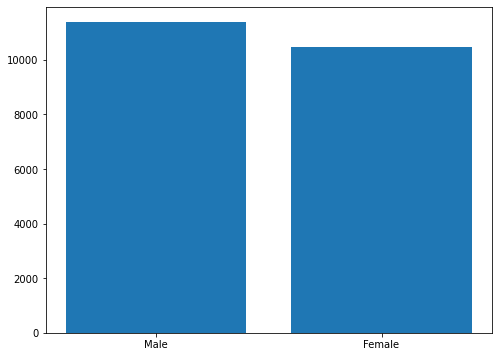

In [12]:
aux = M['sex'].value_counts()
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(aux.index, aux.values)

Note that there are some NaN values for age. We no not know if these are real NaN values or if they were set that way since, as the documentation says: "*ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards*". There is no best way to treat these NaN values since either setting them to be the mean, using a constant value as 0 or 90, etc all can induce bias. However, just to not remove any register, we opt to set those values to 90.

# registers with NaN age:  89


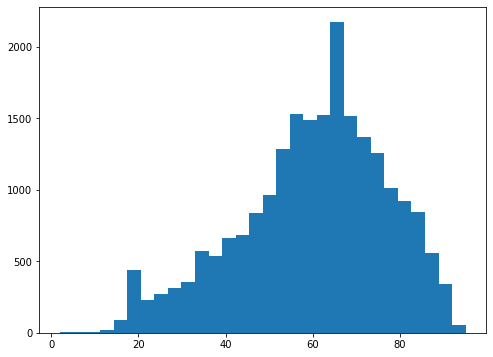

In [13]:
try:
    M['age'] = M['age'].apply(lambda x : 'NaN' if np.isnan(x) else x)
except TypeError:
    pass

print('# registers with NaN age: ', len(M[M['age'] == 'NaN']))
# Correct the NaN ages

M['age'] = M['age'].apply(lambda x : 90 if x == 'NaN' else int(x))
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(M['age'], bins=30);

### PTB-XL Superclasses

The PTB-XL db can be obtained from both the Physionet Challenge (https://physionet.org/content/challenge-2020/1.0.2/) and on its own (https://physionet.org/content/ptb-xl/1.0.3/). 

When downloaded on its own, we get a different set of classifiers that they used to group the diagnoses. These come in 3 ways, which we call superclasses, classes and subclasses. As the hierarchy implies, superclasses are the most general, and contain only 5 labels: NORM, MI, STTC, CD and HYP.

We load the data for the superclasses, leveraging on the following function which contains code that was minimally modified from the sample code provided in the PTB-XL files. This function takes a lot of time, so we rather load the resulting csv file if it has already been created.

In [14]:
if 'Y_superclasses.csv' not in os.listdir(path):
    # Retrieve the superclass for each register
    # and store it
    ecg.y_superclasses(path_to_load='data/ptbxl_database.csv',
                       path_to_store='data/PTB-XL/Y_superclasses.csv',
                       scp_statements='data/scp_statements.csv')

Read the previously calculated DF:

In [15]:
Y_superclasses = pd.read_csv(path + 'Y_superclasses.csv', index_col=0)

These are the definitions for the 5 superclasses within the PTB-XL Database:

    NORM : Normal ECG
    HYP : Hypertrophy
    CD : Conduction Disturbance
    STTC : ST/T Change
    MI : Myocardial Infarction

The distribution of them is as follows:

<BarContainer object of 5 artists>

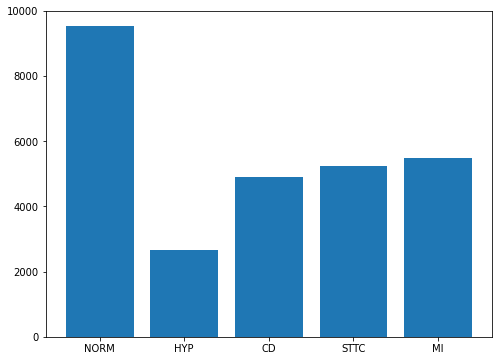

In [16]:
aux = Y_superclasses.sum(0)
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(aux.index, aux.values)

We are mostly interested in the MI class. We can see that around 25% of the dataset has been classified as MI, which is a decent amount of registers to learn from.

# registers belonging to MI:  5486
% registers belonging to MI:  25.12


<BarContainer object of 2 artists>

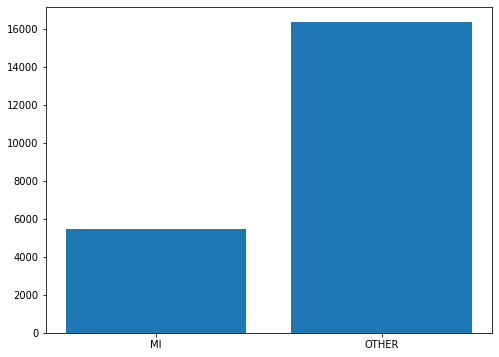

In [17]:
Y_mi = Y_superclasses[['MI']].copy()
print('# registers belonging to MI: ', np.sum(Y_mi['MI']))
print('% registers belonging to MI: ', round(100 * np.mean(Y_mi['MI']), 2))
aux = Y_mi.sum(0)
aux['OTHER'] = len(Y_mi) - aux['MI']
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(aux.index, aux.values)

Another approach of interest is to differentiate between the MI and STTC classes. The reason for this is that some of the most difficult kinds of MI to detect are those that do not have elevations in the ST segment, which are called NSTEMIs (Non-ST-elevation myocardial infarction). For this reason, we reclassify into non-intersecting agroupations as follows, in hope that our data and models will be able to detect NSTEMIs:

    i. MI (no STTC)
    ii. STTC (no MI)
    iii MI & STTC
    iv. Other

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------

**Note**: It is worth mentioning a very important thing to keep in mind. The data from PTB-XL was, up to what I understood from reading the documentation, labelled in an a priori way. What we mean by this is that each register was labelled just from looking at the ECG, either by a cardiologist or by automatic interpretation by an ECG-device. That means that some regisers that should be classified as MI could have gone unnoticed, given the difficulty in detecting MI without STTC elevations.

In my opinion, the best way to actually detect NSTEMIs is if we had a way to label data in an a posteriori way. That is, to have the ECG data labelled some time after its initial recording, and taking into consideration 2 things: The results of blood tests, angiograms and other techniques that could detect the MI, and whether the patient actually suffered an MI.

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------

The distribution with this approach shows that there are a lot of registers classified as MI that did not have a change in the ST segment. That actually goes against what we knew, in that most MIs were detected through an elevation (which in theory could be considered a change) in the ST segment. Given this, it would be best to make an analysis on what they are considering for something to fall in the STTC class, since it might have nothing to do with our pursue of idenifying NSTEMIs.

<BarContainer object of 4 artists>

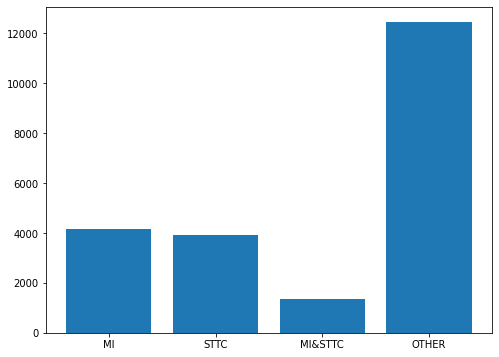

In [18]:
Y_mi_sttc = ecg.y_mi_sttc(Y_superclasses)
aux = Y_mi_sttc.sum(0)
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(aux.index, aux.values)

### One-Hot Encoding for SNOMED CT Codes

Now that we have the diagnoses for each register, we process it to have in a way that the models can use them. That is, to have all the SNOMED CT Codes as columns, and each register will have a 0 in any column if the patient does not have the given dx, and 1 otherwise.  

This one takes quite a long time, possibly around 10 minutes, so we store it for future uses.

In [19]:
if 'Y_snomed.csv' not in os.listdir(path):
    
    # For each register, we expand the dx into a 
    # One-Hot Encoding format
    Y_snomed = md.y_labelling(Y['dx'], labels.index)
    Y_snomed.to_csv(path + 'Y_snomed.csv')
    
Y_snomed = pd.read_csv(path + 'Y_snomed.csv', index_col=0)

This is a sparse matrix, since there are a lot of possible dx, and people usually have only 1 dx.

In [20]:
Y_snomed.head()

270492004  164889003  164890007  426627000  713427006  713426002  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   445118002  39732003  164909002  251146004  ...  81898007  164896001  \
0          0         0          0          1  ...         0          0   
1          0         0          0          0  ...         0          0   
2          0         0          0          0  ...         0          0   
3          0         0          0          0  ...         0          0   
4          0         0          0          0  ...         0          0   

   111288001  266249003  251266004  195060002  164895002  251180001  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   195101003  74390002  
0          0         0  
1          0         0  
2          0         0  
3          0         0  
4          0         0  

[5 rows x 111 columns]

There are many dx that have very few observations. This is not favorable for a classification problem. Having an imbalanced dataset with respect to the target variable can heavily bias the model to only learn what the majority of the labels are.

c:\users\mike\appdata\local\programs\python\python39\lib\site-packages\pandas\core\dtypes\cast.py:1097: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)


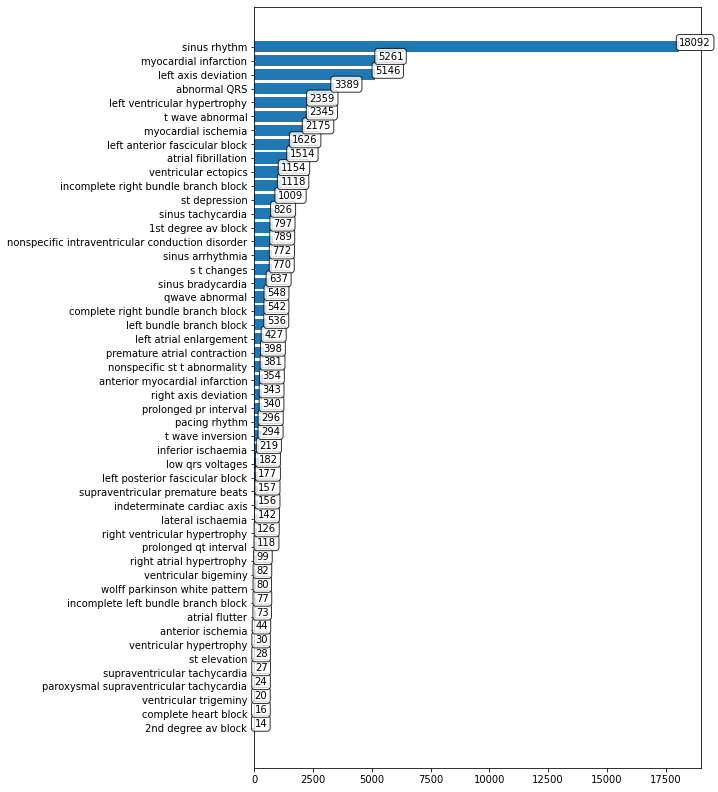

In [21]:
# Get value counts of each dx
aux = Y_snomed.sum(0)
aux = aux.sort_values()
aux = aux[aux > 0]
aux.index = aux.index.astype(float).astype(int)
aux.index = [labels.loc[idx, 'Diagnostic Description'] for idx in aux.index]

# Plot
fig, ax = plt.subplots(figsize=(8,14))
ax.barh(aux.index, aux.values)
# Get the rectangles/bars for each of the dx
rectangles = [x for x in ax.get_children() if isinstance(x, matplotlib.patches.Rectangle)][:-1]

# For each, add the text at the end of the bar
for rectangle in rectangles:
    ax.text(rectangle.get_width() - aux.values.min()/2,
            rectangle.xy[1] + rectangle.get_height()/1.6,
            rectangle.get_width(),
            size=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)  )

# 

### Types of Noise

Through several revisions with the doctors working in this project, we were able to understand what composes a usual ECG, and more importantly, which patterns are associated to noise and not to the diagnoses. To keep it simple, there are basically 3 kinds of noise: Baseline drift, high frequency and unexpected patterns. These can be generated by many reasons, like not having calibrated the device correctly, muscular spasms, voltage peaks, etc.

We will present an example of each of these.

**Standard Signal:** Here is an example of a signal that has no issues whatsoever. We add it as refence to compare it with other signals with noise.

Text(0, 0.5, 'V2')

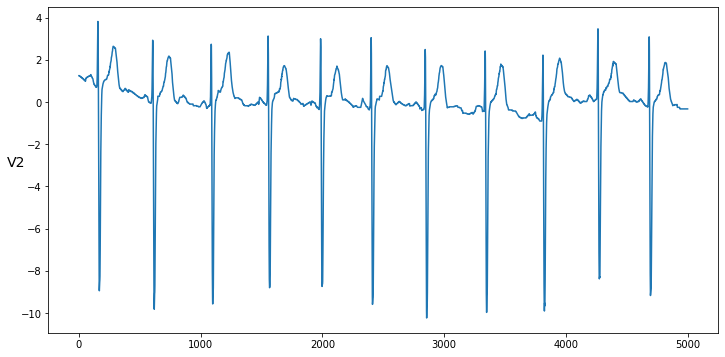

In [22]:
k, s = 4, 7
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, s])
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

**Baseline Drift:** ECGs should be centered around a given baseline. This will be easier to show than to explain, but in essence this means that there should not be any trend component present in the signal. This is actually very common in this database, and it happens in a wide range of severity. This does not mean that we cannot use this database: People with the knowledge to interpret an ECG know this happens and can differentiate this from the patterns that are actually associated to diagnoses. The baseline for these registers seems to be 0, so we will use it from here on.

This is an example of a register with a very heavy baseline drift:

Text(0, 0.5, 'V1')

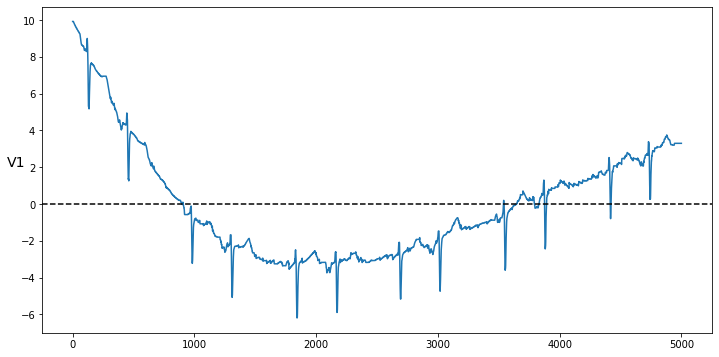

In [23]:
k, s = 2300, 6
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, s])
ax.axhline(0, ls='--', color='k')
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

Baseline drift comes in many ways. Here are 2 more examples of how diverse it can look.

Text(0, 0.5, 'V5')

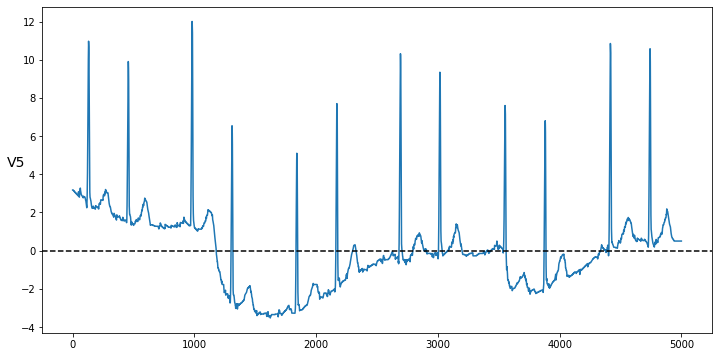

In [24]:
k, s = 2300, 10
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, s])
ax.axhline(0, ls='--', color='k')
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

Text(0, 0.5, 'II')

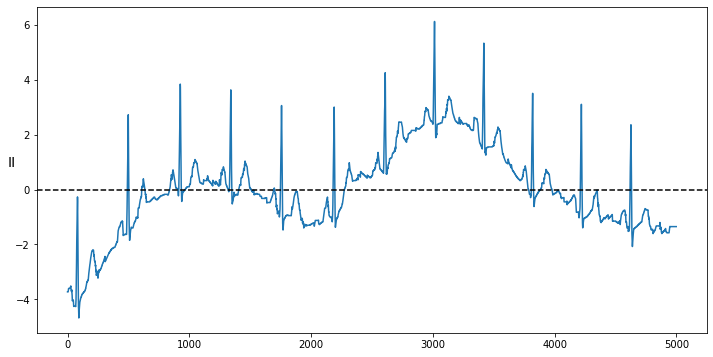

In [25]:
k, s = 2345, 1
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, s])
ax.axhline(0, ls='--', color='k')
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

The majority of registers actually have a very minor baseline drift:

Text(0, 0.5, 'II')

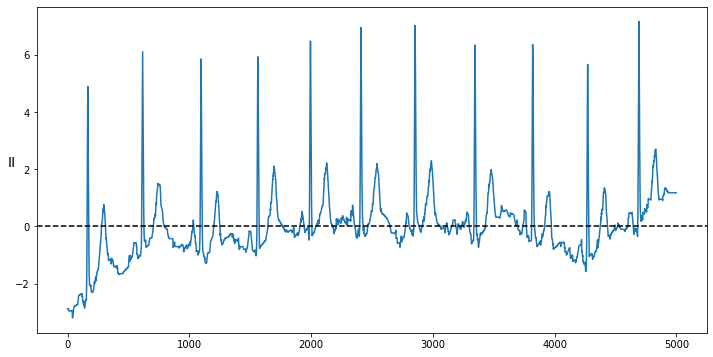

In [26]:
k, s = 4, 1
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, s])
ax.axhline(0, ls='--', color='k')
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

**High Frequency:** Some registers have a very high frequency, which makes it look very messy and could in turn affect the model's predictive power.

Text(0, 0.5, 'I')

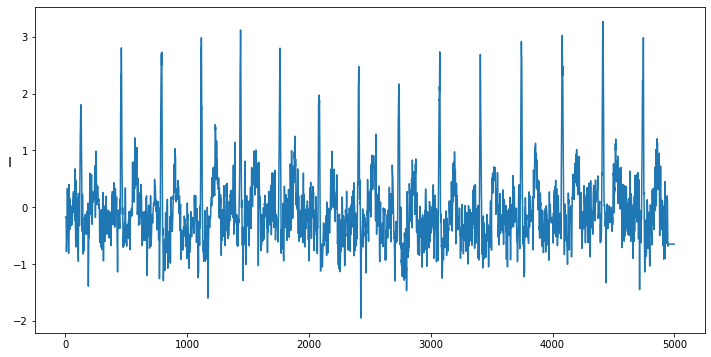

In [27]:
k, s = 13002, 0
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, s])
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

**Unexpected Patterns:** In this category we gather any other weird noise patterns.

Text(0, 0.5, 'V2')

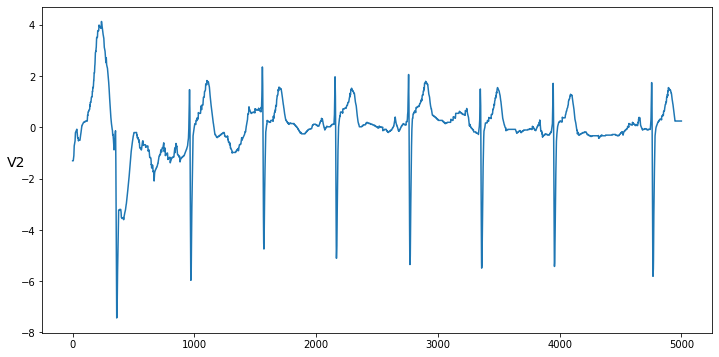

In [28]:
k, s = 2358, 7
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, s])
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

### Ideas to Correct Noise

As we have seen, there are different noise patterns that do not add anything to the model's ability to correctly make a diagnosis. Doctors can filter out visually these noises, but the model might not so easily. For this reason, we propose to make some corrections to the data. These are by no means the only nor the best ways to proceed, but we will work them in hopes of them helping out the model's predictive power.

    Baseline Drift      : Apply median filtering
    High Frequency      : Apply bandpass filtering
    Unexpected Patterns : Remove outliers 
    
We will further explain throughout this notebook each methodology.

**Note:** At the moment, this notebook will be delivered as part of my research project to graduate from my masters. I explored the way to correct the Baseline Drift and partially the Unexpected Patterns. The use of bandpass filtering to correct High Frequency was not explored yet.

### Correcting the Baseline Drift

In an attempt to correct the baseline drift, we will use a techinque called median filtering. In escence, we will calculate the moving median for the signal and substract it in order to get a 0 centered new signal.

This strategy is not bulletproof. It is sensible to the value of the rolling window or filter size used to calculate the median, as well as to very noisy registers. In the following section, we explain how we determined a sensible value for the filter size, and how median filtering also allowed us to detect very noisy registers, which in a way can be considered outliers that could be eventually removed from the dataset.

Here is an example of a very standard signal, which contains a very modest baseline drift:

Even with a very standard example, we can already detect something that should not be happening: There are trend components. What we mean by this, is that the signal is not centered around the baseline (we can assume it's 0 visually, but even if its 0.5 or some other value, the drift is notable).

The ECG should only be capturing (somewhat) repetitive patterns centered around a baseline. However, we can see that there are similar patterns ocurring below (red ellipse) and above (green ellipse) the baseline.

Text(0, 0.5, 'II')

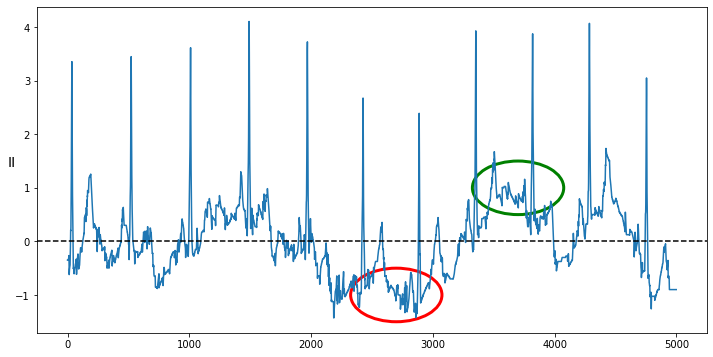

In [33]:
k, s = 2, 1

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X[k][:, s])
ax.axhline(0, ls='--', color='k')
ax.add_patch(Ellipse((2700, -1), 750, 1, color='r', fill=False, lw=3))
ax.add_patch(Ellipse((3700, 1), 750, 1, color='g', fill=False, lw=3))
ax.set_ylabel('II', rotation=0, fontsize=14)

#### Own methodology

We coded a simple median filtering algorithm ourseleves for some simple tests. This algorithm takes a rolling window size (let's call it *n_window*) as a parameter. With it, we use the pd.rolling function to take subsequent *n_window* sized chunks up until the end of the series. 

This gives us *n* - *n_window* + 1 chunks, for each of which we calculate the median. We can then fill the first *n_window* - 1 values in the most simple way by assigning a value of 0 to each one. This will be the median series, which we will substract to the original values to get a 0 centered new series.

We apply this to the previously seen example, and verify that indeed now the signal is centered around 0. The red and green ellipses indicate where the values were centered previously.

Text(0, 0.5, 'II')

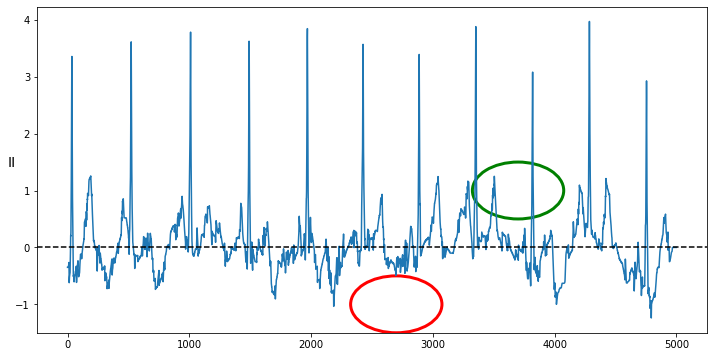

In [34]:
k, s = 2, 1
x = ecg.ud_median_filter_ecg(X[k], rolling_window=200, correct_first=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x[:, s])
ax.axhline(0, ls='--', color='k')
ax.add_patch(Ellipse((2700, -1), 750, 1, color='r', fill=False, lw=3))
ax.add_patch(Ellipse((3700, 1), 750, 1, color='g', fill=False, lw=3))
ax.set_ylabel('II', rotation=0, fontsize=14)

You may be wondering if simply assinging 0 to the first *n_window* - 1 registers of the median series would work for any case. Of course, if the original series is not slightly centered around 0 in the first values, then substracting 0 from it won't change anything.

Here we have such a case. The following is the original signal for a register whose initial values are considerably far from 0.

Text(0, 0.5, 'II')

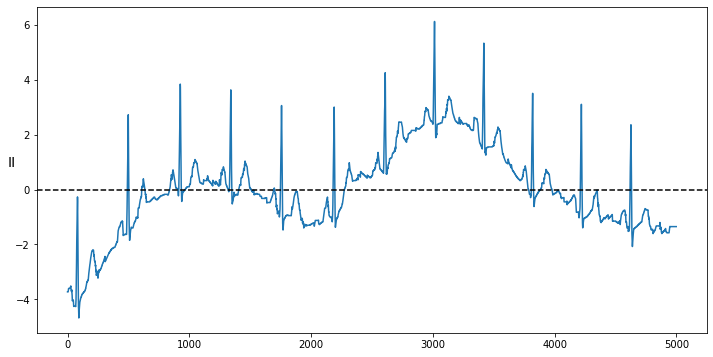

In [35]:
k = 2345
example = wfdb.rdsamp(path+hea_files[k])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(example[0][:, 1])
ax.axhline(0, ls='--', color='k')
ax.set_ylabel('II', rotation=0, fontsize=14)

With our methodology, the first *n_window* - 1 registers remained far from 0 as expected.

Text(0, 0.5, 'II')

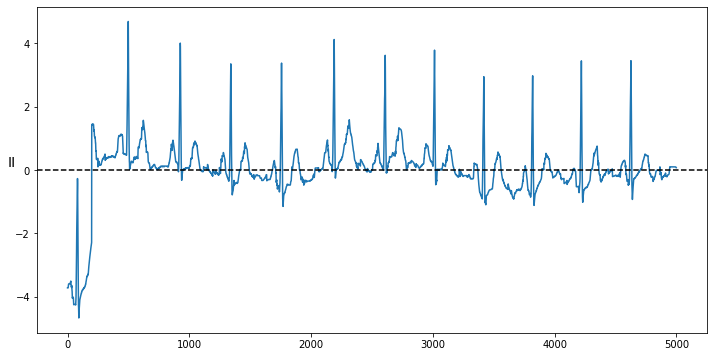

In [36]:
x = ecg.ud_median_filter_ecg(X[k], rolling_window=200, correct_first=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x[:, 1])
ax.axhline(0, ls='--', color='k')
ax.set_ylabel('II', rotation=0, fontsize=14)

We altered the function to correct for this in the following way: The first *n_window* - 1 values of the median series will be calculated using a reversed version of the original series. That is, we simply turn the signal around and calculate the *n_window* sized median of each of the *n_window* - 1 first (though now they are last in the reveresed series) values.

This is the new series having substracted the median, which does not have the issues in the first values that the previous version had:

Text(0, 0.5, 'II')

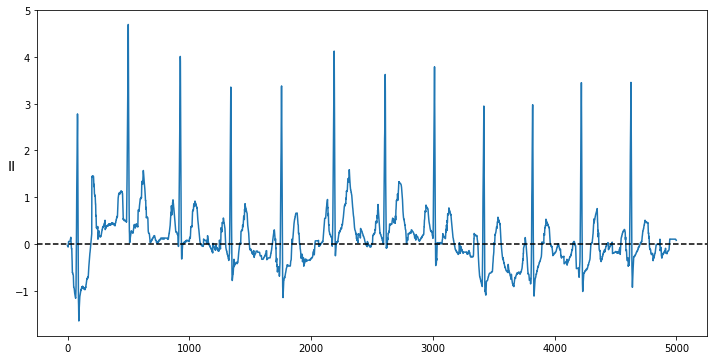

In [37]:
x = ecg.ud_median_filter_ecg(X[k], rolling_window=200, correct_first=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x[:, 1])
ax.axhline(0, ls='--', color='k')
ax.set_ylabel('II', rotation=0, fontsize=14)

However, we can see that all of the baseline drift has not been removed. There are still repeated patterns that sometimes occur on top of the baseline and other times at the baseline. Thing is, a median filter using rolling windows can only get us so far.


#### scipy's median_filter function

A better way to apply median filtering for our case is to use filters centered in each value. For example, given a 5000 points series and a 21 size filter, for a given point, say point number 2250, we would use the values points 2240, 2241, ... , all the way to 2260 and calculate the median with these.

Whilst programming this would not be terribly complicated, we will leverage on the preexisting function from scipy named *median_filter*. This also benefits us in computing time, since these functions are already optimized. 

It also allows us to use the preloaded methods to deal with values at the boundaries. Say again we have 5000 points and a 21 size filter. Then the points 1, 2, ... 10 and 4990, ... 5000 do not have enough values around themeselves for the median to be calculated. This function allows us to select different methods to deal with this, such as simply setting a predefined constant value, using the nearest value, etc.

There is no best way to select one of these methods, but one of the most sensible for our purposes is to reflect values at the start and end of the series. For example, point 5 will use the following values to calculate its median: {5, 4, 3, 2, 1, 1, 2, 3, 4, 5, ..., 15}.

We apply this function to the example we have been working with, and we can see now that most of the baseline drift has been removed, with appearently no loss of information.

Text(0, 0.5, 'II')

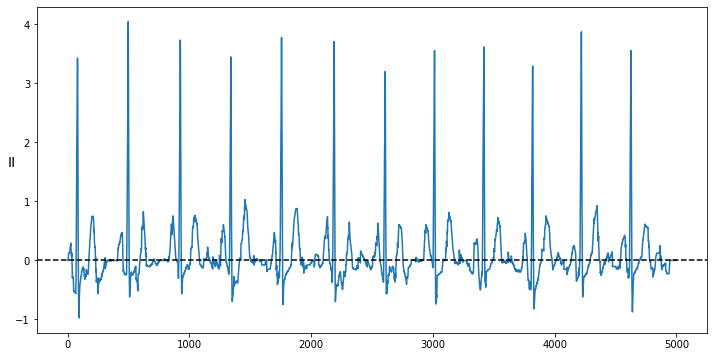

In [38]:
x = ecg.sp_median_filter(X[k][:, 1], size=200, mode='reflect')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x)
ax.axhline(0, ls='--', color='k')
ax.set_ylabel('II', rotation=0, fontsize=14)

However, not everything is great about this function. Even though it provides a better way to filter the series, it has a huge flaw: It takes way too much time. Let's assume we were to proceed to clean the data with this filter, and apply it to each of the 12 signals of the (approximately) 21,000 records.

The following is an approximate of the amount of time it would take, in days, to clean this data:

In [39]:
start_time = time.time()
for k in [0, 1, 2, 3, 4]:
    x = ecg.sp_median_filter(X[k][:, 0], size=200, mode='reflect')    
total_time = time.time() - start_time

# By 21_000 since those are the total registers
# Divided by 3 for average time
# Divided by 60, 60 and 24 to convert from seconds to days
expected_days = 12 * 21_000 * total_time / 3 / 60 / 60 / 24

print(f'Expected number of days to process all signals: {expected_days}')

Expected number of days to process all signals: 3.8412133521503873


This is a huge time commitment. What if, in the future, we found that another size of the filter is better to clean the data. Then we would have to wait a similar amount of time (it decreases for lower sizes and increases the other way around) just to process our data, let alone train it.

#### tensorflows's median_filter2d function

We will eventually need to use a framework like tensorflow or pytorch to even be able to train deep learning models. So, if we will anyway use them, why not take advantage of them to also preprocess the data? To our benefit, there exists a tensorflow implementation of the median filtering function, called median_filter2d.

We verify that, given the same filter size and mode, we get the same results as the scipy implementation, with a massive time decrease using tensorflow.

**Note:** This cell might have to be run twice in order to "turn on" tensorflow and get the correct amount of seconds each register takes.

Time used with scipy: 2.4499990940093994 seconds
Time used with tensorflow: 0.003000974655151367 seconds


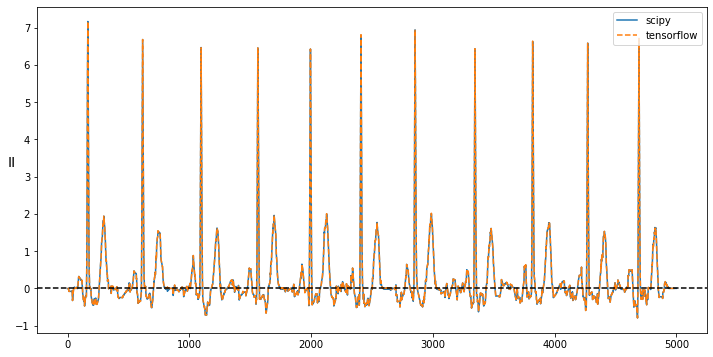

In [41]:
start_time = time.time()
x_sp = ecg.sp_median_filter(X[k][:, 1], size=200, mode='reflect')
print(f'Time used with scipy: {time.time() - start_time} seconds')
start_time = time.time()
x_tf = ecg.tf_median_filter(X[k][:, 1], filter_shape=200, padding='reflect')
print(f'Time used with tensorflow: {time.time() - start_time} seconds')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_sp, label='scipy')
ax.plot(x_tf, label='tensorflow', linestyle='--')
ax.axhline(0, ls='--', color='k')
ax.set_ylabel('II', rotation=0, fontsize=14)
plt.legend()

#### Apply function with tensorflow

We will try to use tensorflow as most as we can, since operations using GPU are considerably faster than regular ones. We will use *tf.map_fn* to apply the median filter to all of the registers.

This will be done after we make some tests regarding outliers, but for the moment, we show how fast we could transform the whole dataset.

In [42]:
start_time = time.time()
n = 100
# This is the median function that will be applied to each ecg
f = lambda x: tfa.image.median_filter2d(x, filter_shape=(200, 1),
                                                      padding='reflect') 
# We apply it to the first n ECGs
median_series = tf.map_fn(f, X[:n])
# And correct the series
corrected_series = X[:n] - median_series
print(f'Time used with tf: {round(time.time() - start_time, 2)} seconds for {n} records')
# Estimated time for all registers
estimated_time = X.shape[0] * (time.time() - start_time) / n / 60
print(f'Estimated time used with tf: {round(estimated_time, 2)} minutes for all {X.shape[0]} records')
# Delete variables to free GPU space
del median_series
# del corrected_series

Time used with tf: 4.88 seconds for 100 records
Estimated time used with tf: 17.77 minutes for all 21837 records


### Visualization of the median filter

Up to now, we have just shown the corrected series, that is, the original minus the median filter. We add the following graph to show how the median looks with respect to the signal.

We do this varying the filter size to show how this parameter can greatly affect the final series.

#### Varying filter size

The smaller the filter size is, the more patterns we capture, which can end up removing most of the important information of the ECG. On the other hand, if it's very big, it is not able to accurately detect the trend. We need to select a sensible value that can both capture the trend and not remove important patterns.

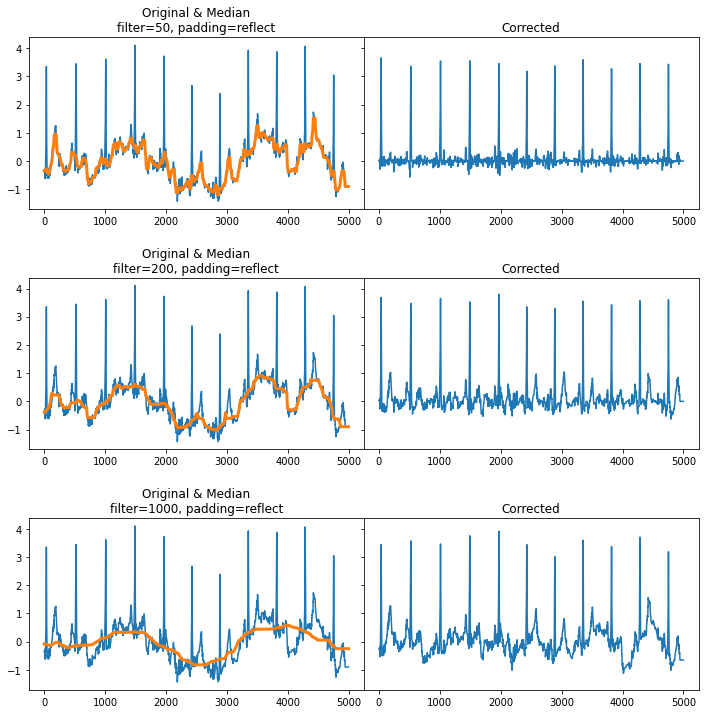

In [43]:
# Select register and signal
k, s = 2, 1
# Define parameters
filter_sizes = [50, 200, 1000]
padding = 'reflect'
# Create figure
fig, axs = plt.subplots(len(filter_sizes), 2, figsize=(12, 4 * len(filter_sizes)), sharey=True)
plt.subplots_adjust(wspace=0.0, hspace=0.4)
# For each combination, plot the original vs the corrected series
for i, filter_size in enumerate(filter_sizes):
    x, med = ecg.tf_median_filter(X[k][:, s], filter_size, padding, return_mf=True)
    ecg.plot_original_vs_corrected(axs[i], X[k][:, s], med, x, filter_size, padding)

#### Choosing a sensible value for the filter size

The doctors received several signals with their corrected values for different filter sizes. After analyzing them, an initial value that seems to be the one that works the best for most signals is a filter size of 200. That is, 200 was the value for which they considered that the diagnoses present in the original series was preserved in the corrected one, while also having the signal centered around 0.

Take into consideration that this was a heuristic approach to determine the value for the filter size. There is no guarantee that it will actually be the best one for the model. Some ideas that can be touched upon in the future are:

    1. Transform all the series with a set filter size and verify which is the one for which our metrics (recall, precision, etc.) outperform all other ones.
    2. Determine in some way if a signal is more adequate to be transformed with a given filter size. For example, even if 200 seems to be the best overall, perhaphs there is one signal in an ECG for which a value of 100 works best. The model (including the data preprocessing step) should be able to detect this and apply the best filter size for each signal of every ECG.

These ideas are out of the scope of this project since they require a lot of time to test. For the moment, we will use the heuristic approach and set a filter size of 200 for every signal.

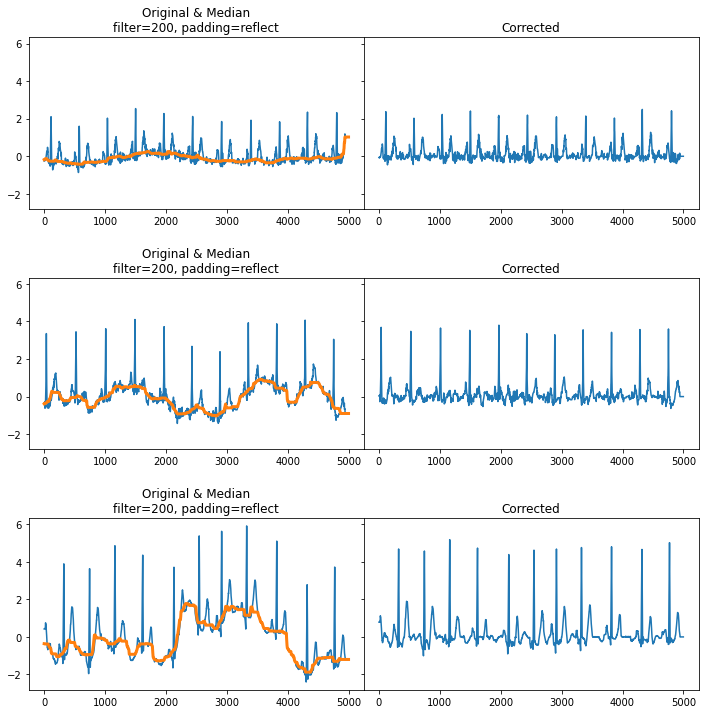

In [44]:
# Select register and signal
ks, s = [0, 2, 10], 1
# Define parameters
filter_size = 200
padding = 'reflect'
# Create figure
fig, axs = plt.subplots(len(ks), 2, figsize=(12, 4 * len(ks)), sharey=True)
plt.subplots_adjust(wspace=0.0, hspace=0.4)
# For each combination, plot the original vs the corrected series
for i, k in enumerate(ks):
    x, med = ecg.tf_median_filter(X[k][:, s], filter_size, padding, return_mf=True)
    ecg.plot_original_vs_corrected(axs[i], X[k][:, s], med, x, filter_size, padding)

#### Outliers : First detection

Having decided on using a filter size of 200, the question is if each and every register will be corrected as expected. We found that there are registers that will not be accurately corrected with this value, but that might indeed be best treated with a different filter size.

The following example does not seem to correct the spikes present in the signal. However, a value of 100 seems to do a better job at it.

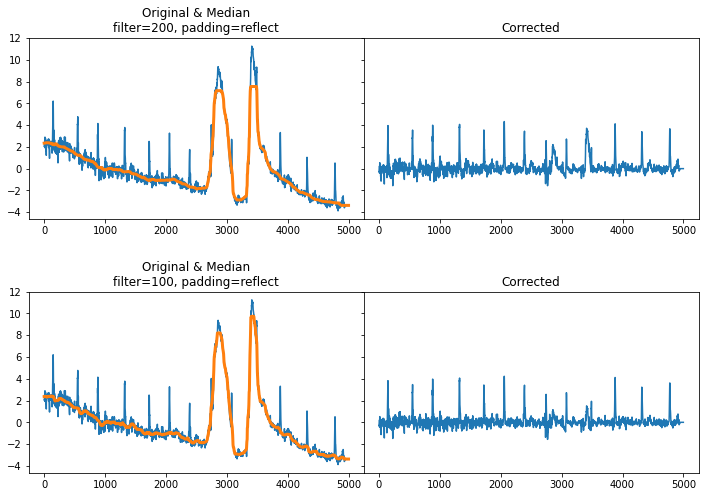

In [45]:
# Select register and signal
k, s = 1501, 0
# Define parameters
filter_sizes = [200, 100]
padding = 'reflect'
# Create figure
fig, axs = plt.subplots(len(filter_sizes), 2, figsize=(12, 4 * len(filter_sizes)), sharey=True)
plt.subplots_adjust(wspace=0.0, hspace=0.4)
# For each combination, plot the original vs the corrected series
for i, filter_size in enumerate(filter_sizes):
    x, med = ecg.tf_median_filter(X[k][:, s], filter_size, padding, return_mf=True)
    ecg.plot_original_vs_corrected(axs[i], X[k][:, s], med, x, filter_size, padding)

### Outlier detection : First attempt

Registers like the one we just saw might muddle the model's capacity to accurately predict the diagnoses. We would like the model to be able to correctly predict given any ECG that it comes across. Nonetheless, as a way to verify if our metrics improve if we remove the outliers, we will perform an outlier detection step and proceed to take them out.

Another reason for doing this, is that in practice, when the medical staff is processing the ECG, they can repeat the process until they get a relatively clean signal, so there is no need to struggle with noisy registers if in real life the model will not receive them frequently.

#### Double median filtering for outlier detection

The idea we will explore to detect outliers is to apply the median filter twice and measure the amount of residual there is between the corrected signal after one iteration vs two iterations of the median filter procedure. The idea is that, if the signal has already been correctly centered, then applying the median filter again should not drastically change it, so the differences should be very small. If the register has not been corrected after one iteration, then the differences between the first and second iterations should be notable.

We will use the following metric to quantify the difference between the first and second iteration of the median filtering:

$$    
E(\textbf{x}_1, \textbf{x}_2) = \frac{\Sigma_{k=1}^n (x_{1, k} - x_{2, k})^2}{\sigma_1^2}
$$

Where:

$$
\textbf{x}_1 : \text{Vector containing the values corrected after one application of the median filtering.} \newline
\textbf{x}_2 : \text{Vector containing the values corrected after two applications of the median filtering.} \newline
\sigma_1^2 : \text{Variance of } \textbf{x}_1.
$$

The reasoning behind this formula is that it quantifies the overall error while also weighting it by the overall range of the signal. We do this to account for series that may have overall small nominal values, but very big differences, as well as series that have big nominal values but small errors.

**Example of a regular register:**

The following is an example of a well behaved signal, in which the second iteration of the median filtering does not seem to be correcting anything more than the first one had.

E = 15.8677


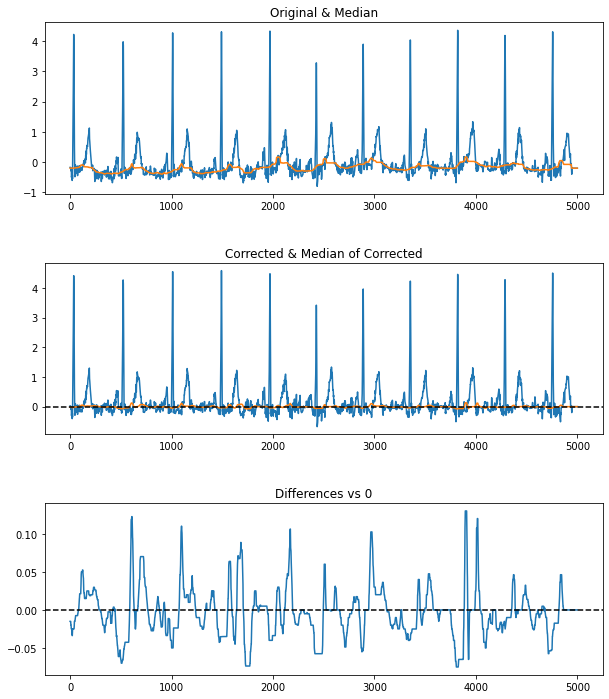

In [46]:
# Choose ecg and signal
k, s = 2, 0
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_reg = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_reg.numpy(), 4)}')

**Example of an outlier:**

The following is an example of a register for which the second median filter does seem to capture some new patterns. Note how different is the value of *E* for the previous example vs this one.

E = 80.8093


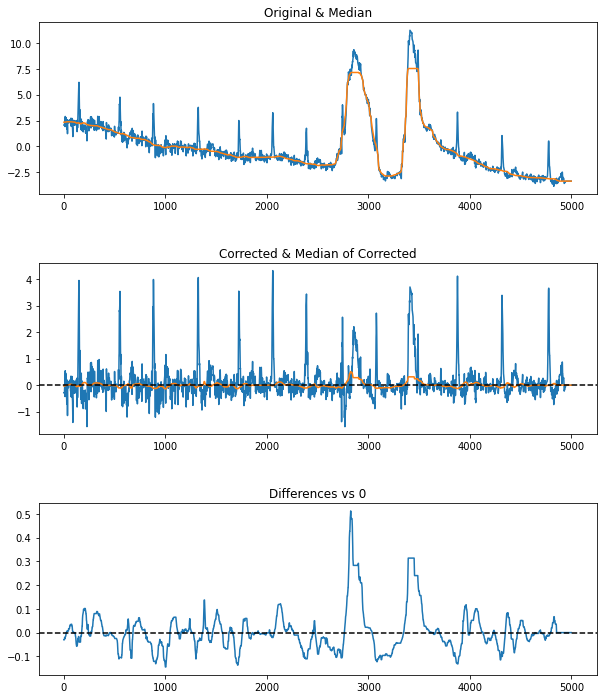

In [47]:
# Choose ecg and signal
k, s = 1501, 0
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_out.numpy(), 4)}')

#### Scale invariance

Notice how in the regular example, the second median filter has values at around -0.05 and 0.1, while the second one has values between -0.1 and 0.5. This is due to the first one having values for the original series between -1 and 4, while the second one has values between -2.5 and 10. So, a question might arise: Won't series that have a wider range be more frequently considered outliers?

The metric we defined actually accounts for this. To exemplify this, let's scale both examples. We will divide both by the maximum absolute value, so that the highest number any series can have is 1 or -1. Then, both series will have a very similar range. We calculate E for both scaled series. 

Given that we are weighting by the variance, we can see that E is the same as before, so the metric is scale invariant and thus we do not have to worry for registers that have a very wide range to be falsly considered as outliers.

In [48]:
# Repeat everything for the now scaled values
k, s = 2, 0
aux = X[k][:, s].copy()
aux_max = max(aux.max(), -1*aux.min())
aux = aux / aux_max
x, med = ecg.tf_median_filter(aux, 200, 'reflect', return_mf=True)
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Calculate the new values of E and compare
e_reg_sc = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print('Regular example:')
print(f'E = {round(e_reg.numpy(), 4)} for the unscaled values')
print(f'E = {round(e_reg_sc.numpy(), 4)}  for the scaled values')

# Repeat everything for the now scaled values
k, s = 1501, 0
aux = X[k][:, s].copy()
aux_max = max(aux.max(), -1*aux.min())
aux = aux / aux_max
x, med = ecg.tf_median_filter(aux, 200, 'reflect', return_mf=True)
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Calculate the new values of E and compare
e_out_sc = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print('\nOutlier example:')
print(f'E = {round(e_out.numpy(), 4)} for the unscaled values')
print(f'E = {round(e_out_sc.numpy(), 4)}  for the scaled values')

Regular example:
E = 15.8677 for the unscaled values
E = 15.8647  for the scaled values

Outlier example:
E = 80.8093 for the unscaled values
E = 80.8091  for the scaled values


#### Setting thresholds : Calculate E for a sample

Once that we calcualte E for each signal  of every register, we have to decide how much E has to be for any ecg to be considered an outlier. We can plot a histogram of E for each of the signals and verify if there is a clear cut which can be induced.

Given the limitations we have in terms of computational resources, we cannot have in memory the values of all the original series plus the series after one median filter plus the series after two filters. To circumvent this, we will run bacthes of registers and store E for every register in each batch.

In [49]:
filter_shape = 200
files_in_path = os.listdir(path)
if f'E_{filter_shape}.csv' not in files_in_path:
    
    ### If we ever get enough computational resources, this is the code
    # to do everything in one sweep
    # X_1 = ecg.tf_median_filter_ecgs(X, 200, 'reflect')
    # X_2 = ecg.tf_median_filter_ecgs(X_1.numpy(), 200, 'reflect')
    # E = tf.math.reduce_sum((X_1 - X_2) ** 2, axis=(1)) / tf.math.reduce_variance(X_1, axis=(1))

    n = X.shape[0]
    batches = np.linspace(0, n, 20).astype(int)
#     batches = np.linspace(0, n // 10, 20).astype(int)

    for i in range(len(batches)-1):  
        print(f'Batch {i+1} of {len(batches)-1} : Registers {batches[i]} to {batches[i+1]}')
        # Calculate the first median filter correction
        X_1 = ecg.tf_median_filter_ecgs(X[batches[i]:batches[i+1]], filter_shape, 'reflect')
        # Calculate the second median filter correction
        X_2 = ecg.tf_median_filter_ecgs(X_1.numpy(), filter_shape, 'reflect')
        # Calculate E for the given registers
        e = tf.math.reduce_sum((X_1 - X_2) ** 2, axis=(1)) / tf.math.reduce_variance(X_1, axis=(1))
        # We concatenate new values of E as they are calculated
        if i == 0:
            E = e
        else:
            E = tf.concat([E, e], axis=0)
        # We delete the variables to free up memory.
        # In theory, once the for loop starts, they are reassigned,
        # but sometimes tf does not clear memory so well,
        # so we rather force this.
        del X_1
        del X_2

    # We save E
    E = E.numpy()
    pd.DataFrame(E).to_csv(path + f'E_{filter_shape}.csv')
    
E = pd.read_csv(path + f'E_{filter_shape}.csv', index_col=0)
E = np.array(E)

We plot the distribution of E for every signal. We can see that it is very common for it to have very heavy tails to the right, indicating there are some registers that are extremely noisy.

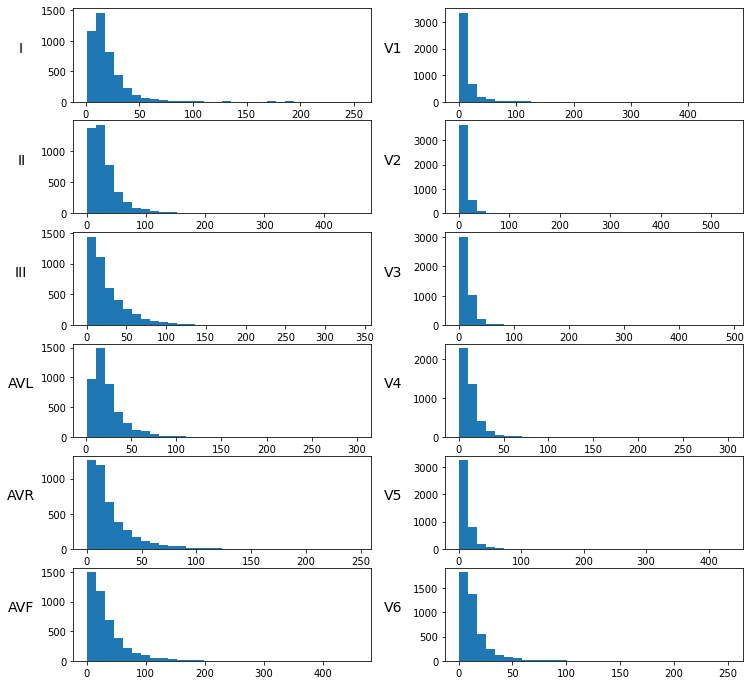

In [50]:
fig, axs = plt.subplots(6, 2, figsize=(12,12))
fig.subplots_adjust(wspace=0.25)
axs = axs.T.ravel()
for channel in range(12):            
    axs[channel].hist(E[:, channel], bins=30)
    axs[channel].set_ylabel(ecg.signals[channel], fontsize=14, rotation=0, labelpad=20)

Even though its more informative to look at the individual distributions by signal, we add a general histogram for the distribution of E across all of them.

Text(0.5, 0, 'E(x₁, x₂)')

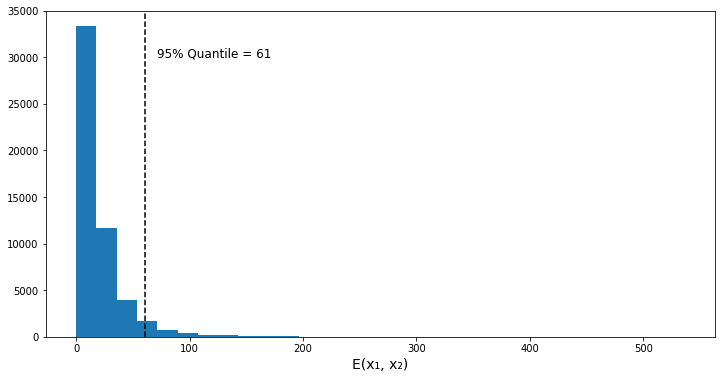

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

eq95 = np.quantile(np.ravel(E), 0.95)
eq95 = int(eq95)
ax.hist(np.ravel(E), bins=30)
ax.axvline(eq95, ls='--', color='k')
ax.text(eq95+10, 30_000, f'95% Quantile = {eq95}', size=12)
ax.set_xlabel('E(x₁, x₂)', fontsize=(14))

#### Storing signals with filter shape = 200 in .csv

We store each of the ECG records after having gone through one median filter.

First we define the general parameters that will be used. 


**Note:** The following cells are commented since we do not have to do this anymore, but we leave it as a reminder to what was done.

In [52]:
# filter_shape = 200
# padding = 'REFLECT'
# path_filter_shape = f'data/PTB-XL_mf={filter_shape}/'
# n_0s = 5

Then, we store in a `.csv` file we store each ECG record. 

In [53]:
# files_in_path = os.listdir(path_filter_shape)
# n = X.shape[0]

# for k in range(n):
    
#     k_str = str(k+1)
#     HR = 'HR' + '0' * (n_0s - len(k_str)) + k_str
    
#     if HR + '.csv' not in files_in_path:
        
#         x = X[k].copy()
#         x = ecg.tf_median_filter_ecg(x, filter_shape=filter_shape, padding=padding, return_np=True)
#         np.savetxt(path_filter_shape + HR + '.csv', x, delimiter=',')

#### Storing signals with filter shape = 200 in npy

As we did with the original ECGs, we will store them in `.npy` files that drastically improve the loading time of the records.

The following cell is commented since we did this for all of the regsters, in chunks of 5000 registers each. We do not need to run it again, so we just leave this cell as a reminder of what was done.

In [54]:
# X = pd.read_csv(path_filter_shape + 'HR20001.csv', header=None)
# X = np.array(X, dtype=np.float16)

# x = pd.read_csv(path_filter_shape + 'HR20002.csv', header=None)
# x = np.array(x, dtype=np.float16)

# X = np.array([X, x])

# for k in range(3 + 20000, 21838):
    
#     k_str = str(k)
#     HR = 'HR' + '0' * (n_0s - len(k_str)) + k_str
    
#     x = pd.read_csv(path_filter_shape + HR + '.csv', header=None)
#     x = np.array(x, dtype=np.float16)
    
#     X = np.concatenate([X, x.reshape(1, 5000, 12)], axis=0)

# np.save(path_filter_shape + 'X_20001_21837', X)

Now that we have it in chunks, we can more easily load them, paste them, and store the whole dataset in an `.npy` file like we did for the original dataset.

In [55]:
# files_to_load = ['X_1_5000.npy', 'X_5001_10000.npy', 'X_10001_15000.npy', 
#                  'X_15001_20000.npy', 'X_20001_21837.npy']

# X = np.load(path_filter_shape + files_to_load[0])

# for file in files_to_load[1:]:
    
#     x = np.load(path_filter_shape + file)
#     X = np.concatenate([X, x])

# np.save(path_filter_shape + 'X_1_21837', X)

We also stored M in the new folder for convenience.

In [56]:
# M.to_csv(path_filter_shape + 'M.csv')

#### Visualization of registers given E

We would expect registers close to 0 to be very well behaved signals with respect to the median filter, and as they deviate from 0, registers should increasingly show more sings of not having been able to be corrected properly. 

**Example of a signal with E close to 0:**

In this example, we are obtaining what we expected: The 200 filter size seems to be catching the trend adequately, and the second median filter has nothing left to capture.

E = 0.7796


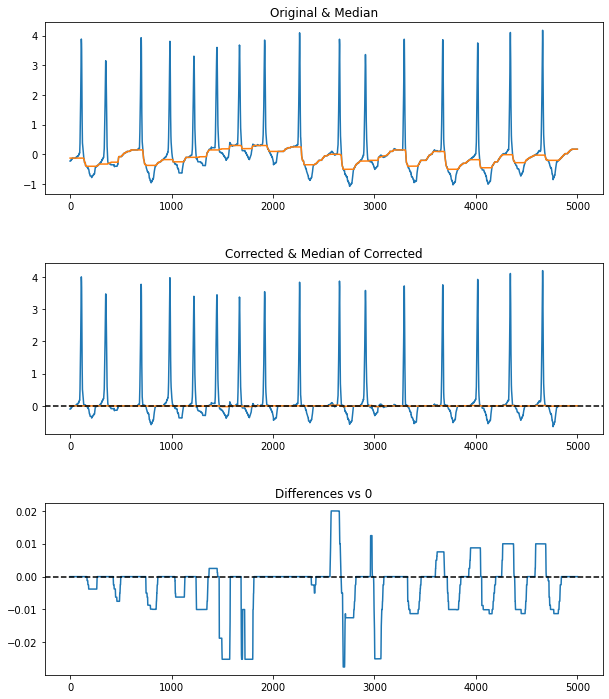

In [57]:
# Choose ecg and signal
s = 1
# k = np.argmin(E[:, s])
k = 1232
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_out.numpy(), 4)}')

**Example of a signal with an extremly high E:**

This example is interesting, and it is happening quite a lot from several examples we checked. What happens is that, visually, the first median filter is already capturing a very decent amount of the trend. Nonetheless, when we apply the second median filter, it still seems to capture a trend pattern significantly enough to make E have a very high value.

E = 284.2458


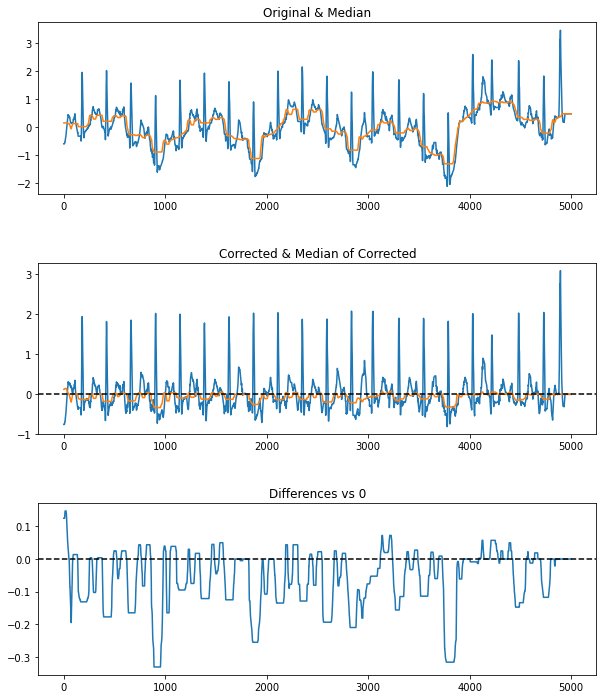

In [58]:
# Choose ecg and signal
s = 11
# k = np.argmax(E[:, s])
k = 4013
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_out.numpy(), 4)}')

Another heavily marked example of a badly corrected register.

E = 272.6913


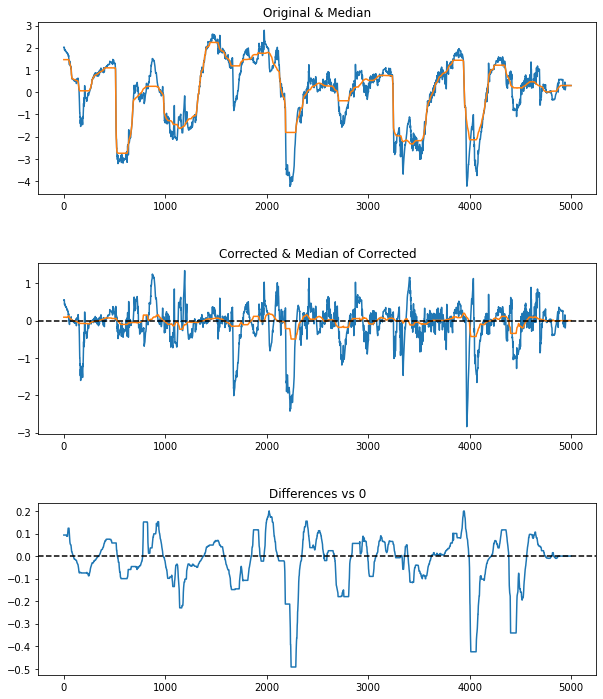

In [59]:
# Choose ecg and signal
s = 4
# k = np.argmax(E[:, s])
k = 1251
# k = 705
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_out.numpy(), 4)}')

#### False negatives and false positives

As we mentioned before, the level of 200 set to correct the signals is not necessarily the best for each and every register, but rather it works for the majority. 

Because of this, we found registers with very high values of E that either seem to be better off corrected with another value for the filter size, or even to have been decently corrected by 200 (but will be considered outliers using a threshold, as in the example we just saw). These are false negatives in the sense that, we are falsely considering them outliers with this value of the filter size.

**Example of false negative:**

Note how the value of 200 is creating a fitted pattern that, because of the signal's own patterns, is directly counterfitting the original one. What we mean is, when the blue (original signal) goes up, the orange one (median filter) goes down. Even though this is happenning, note how the corrected series still preserved the original one's patterns. However, the value of E for this register would make it an immediate candidate to be considered an outlier.

The diagnosis of this ECG is called an *atrial flutter*. It is characterized for consecutive elevations after the expected ST one. This generates signals that seem to have high frequencies, making it so that the 200 filter size will generate the contrary patterns we are watching, though at least it seems to also be capturing the trend as expected.

E = 475.4446


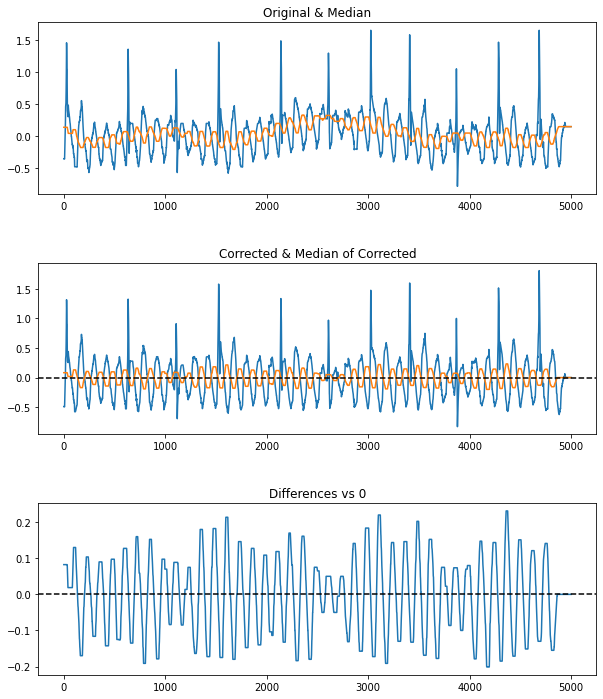

In [60]:
# Choose ecg and signal
s = 1
# k = np.argmax(E[:, s])
k = 705
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_out.numpy(), 4)}')

The same example as above has a value of E very much smaller if we just used a different value for the filter size, but in both cases, the signal is interpretable and conserves its important patterns.

E = 18.9343


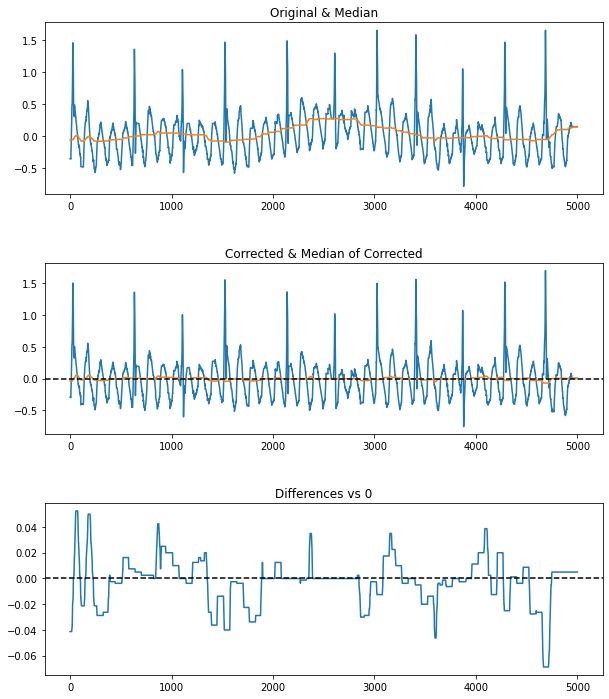

In [61]:
# Choose ecg and signal
s = 1
# k = np.argmax(E[:, s])
k = 705
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 500, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 500, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_out.numpy(), 4)}')

There are signals that, on the other hand, have a very low value of E, but visually they do not look like they have actually been properly corrected.

**Example of a false positive:**

This example has a very low value of E. However, notice how the corrected signal's values before the value of 1000 are very different from the ones after it. Even so, the second median filter simply, as it only tries to capture trend, does not detect any new trend pattern and thus generate a low value of E.

We are perhaps then not being fair with the mechanism we defined: It is indeed removing trend, but it is not able to detect other kind of noises that are important for us to remove, such as in this example.

E = 5.0952


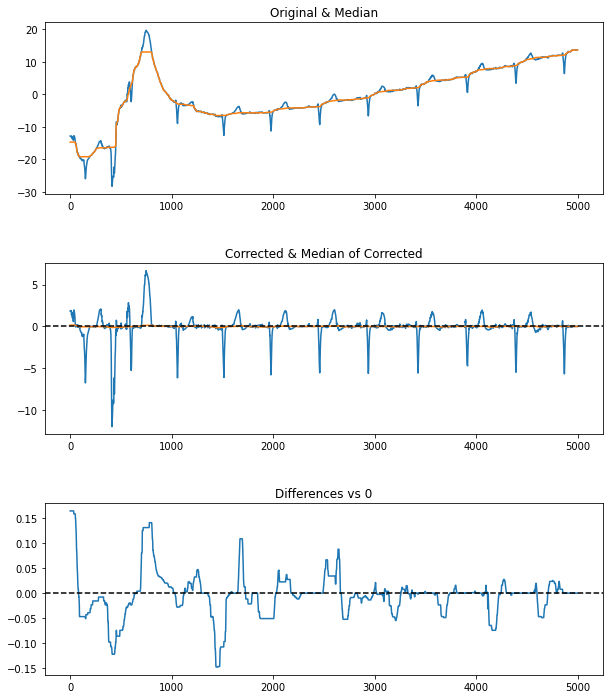

In [62]:
# Choose ecg and signal
s = 8
k = 3277
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
# Apply median filtering twice
x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
# Plot and calculate the value of E
ecg.plot_double_median_filter(X[k][:, s], med, x, med_2)
e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
print(f'E = {round(e_out.numpy(), 4)}')

By the way, we know this is a register with noise and not a generalized pattern since we have access to the other signals. Note how only signals V3 and V4 (perhaphs V2 also) have the unexpected deviations from what is considered a regular ECG.

The min value of this ECG is -28.29 and the max value is 19.73


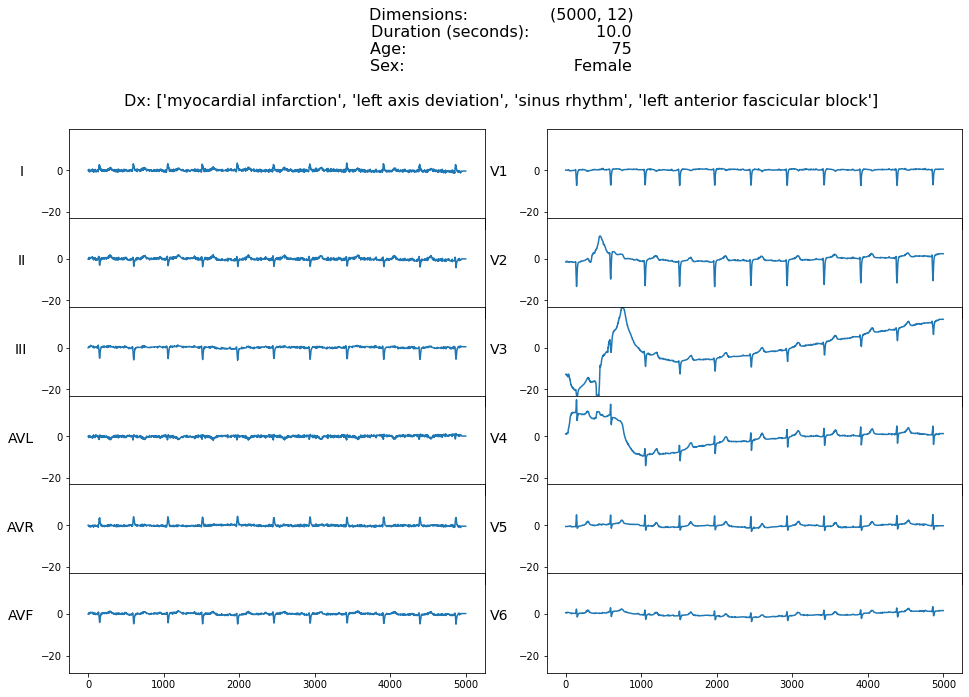

In [63]:
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
print('The min value of this ECG is', example[0].min(), 'and the max value is', example[0].max())
ecg.plot_ecg(example[0], metadata=metadata, ylim=(example[0].min(), example[0].max()))

Here's a summary of the 4 kinds of classification that the E method provides: True and False Positives and Negatives.

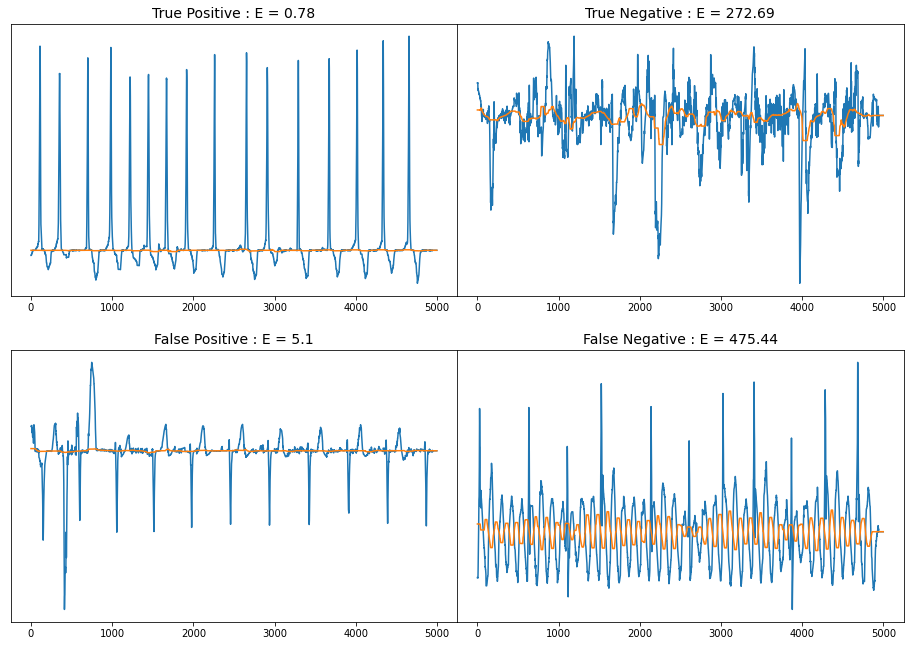

In [64]:
kk = [1232, 1251, 3277, 705]
ss = [1, 4, 8, 1]
titles = ['True Positive', 'True Negative', 'False Positive', 'False Negative']

fig, ax = plt.subplots(2, 2, figsize=(16, 11))
ax = np.ravel(ax)
plt.subplots_adjust(wspace=0.0)

for i, k, s in zip(range(len(ax)), kk, ss):
    x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
    x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
    e = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
    e = round(e.numpy(), 2)
    ax[i].plot(x)
    ax[i].plot(med_2)
    ax[i].set_title(f'{titles[i]} : E = {e}', fontsize=14)
    ax[i].get_yaxis().set_ticks([])

At this point, we are faced with an important matter: Will we gain more, in terms of the model's predictive power, by removing the false negatives, or will we lose more by letting the false positives stay in the dataset?

This question could be ansewered if we could in some way measure the amount of both false negatives and false positives, but that is not viable since that would have us look at each register's plots and determine manually what type they are.

Given this, we will have to create an additional way to complement the proposed mechanism with another criteria to avoid losing false negatives and prevent false positives from leaking.

### QRS and Heart Rate

Before getting into the new criteria for outlier detection, we first need to explain the concepts of the QRS complex and hear rate. These are crucial in traditional ECG interpretation, and will be useful for both the median filtering and the new criteria we will develop later.

#### QRS complex

The traditional ECG signal is composed of repetitions of the electrical acticity that occurs in the heart. The complete explanation of what happens in a full typical cycle will not be adressed in this nb, but the general idea is that the heart receives an initial electrical impulse from the synus node, and consecutively this signal travels through the right and left atriums and ventricules, with one pair in charge of bumping new, oxygen-fulled blood into the body, while the other receives the old blood and sendsit to the lungs to fill it with oxygen.

Within the QRS complex is when the pumping of new blood into the body occurs. It is mostly characterized by a small decline in the electrical signal (Q), followed by a spike (R) and ends with another decline that quickly returns to the baseline (S).

We could (and have) very well fitted a model to the data without ever needing the concept of the QRS complex. However, it will be usefull to know exactly where they are, as we will see briefly.

(image source:https://training.seer.cancer.gov/anatomy/cardiovascular/heart/structure.html).

![alternatvie text](imgs/nb/heart.jpg)

(image source:https://es.m.wikipedia.org/wiki/Archivo:ECG-PQRST%2Bpopis.svg).

![alternatvie text](imgs/nb/pqrst.png)

#### Heart Rate

This concept is probably ubiquitously known, it is simply the rate at which the heart beats for a given period. It is typically measured in beats per minute, with a standard range of 60 to 100 beats per minute for the average person.

#### wfdb to calculate the QRS complexes and Heart Rate

We have already used the *wfdb* in this notebook to retrieve the data from the *.mat* files. However, it also contains some useful functions to calculate the QRS sections and the heartbeat.

For both, we will pass as a parameter a concept that we have not yet explained: The **sample frequency (fs)**. It basically tells us how many records per second are contained in the signal. All of PTB-XL registers have a sample frequency of 500 and a duration of 10 seconds, which explains why we have been observing a range in the x-axis from 0 to 5000 (500 * 10). This is a necessary parameter that will be passed to the *wfdb* functions in order for them to correctly calculate what we need.

The theory behind obtaining the QRS sections is not trivial. It includes steps like applying a bandpass filter and applying moving wave integration, as well as some posterior rules to determine if the segment is an actual QRS segment or if it is just noise. We will not dive into the theory for the moment, but a more detailed explanation can be found in the documentation: https://wfdb.readthedocs.io/en/latest/processing.html.

Th heart rate is much simpler. It is simply an average of the differences of RR lengths (these are the lengths that exist between each consecutive R, which we obtain from knowing where the QRS complexes are) and refactored by the frequency sample:

$$ HR = fs * \frac{60}{\Sigma_{k=1}^{n} {RR}_i} $$

We set the value of the sample frequency (fs) for every further example.

In [65]:
fs = 500

This is an example of a regular signal. The red stars denote the places where there are QRS complexes. Note how the very first R does not have a red star. This will be common moving forward, it happens because the mechanism they use requires to have a decent amount of registers before every QRS segment to accurately detect it. Nonetheless, for our purposes it does not matter, we can work with all the rest.

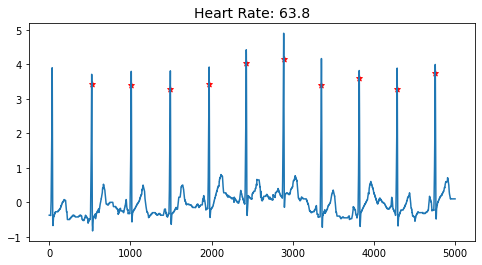

In [66]:
k, s = 2, 10
xqrs, rr, hr = ecg.qrs_rr_and_hr(X[k][:, s], fs)
print()
ecg.plot_qrs(X[k][:, s], xqrs, f'Heart Rate: {round(hr, 2)}')

#### Original vs Corrected

It might come as a doubt whether the QRS complexes and the heart rate can be calculated correclty from registers that have a lot of noise. We tested this and found that, in general, the algorithm behind *wfdb*'s function works regardless of the noise. This is greatly in part due to the robustness that exists behind the theory of their methodology.

For this reason, we will be calculating XQRS complexes and heart rates using the original records. Even though the median filter tries to correct the baseline drift, it induces some unexpected noise as we saw before. If the methodology they developed works well even in the prescence of baseline drift, then there is no need to add said unexpected noise.

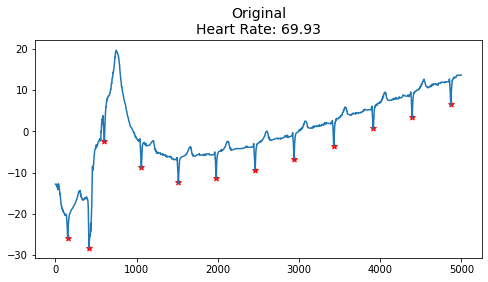

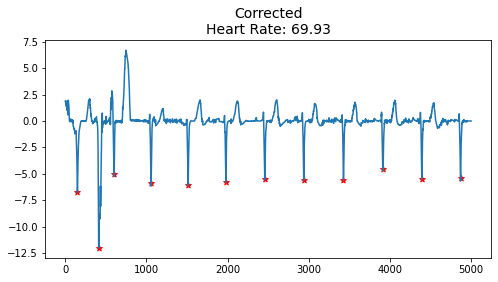

In [67]:
k, s = 3277, 8
xqrs, rr, hr = ecg.qrs_rr_and_hr(X[k][:, s], fs)
ecg.plot_qrs(X[k][:, s], xqrs, f'Original\nHeart Rate: {round(hr, 2)}')
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
xqrs, rr, hr = ecg.qrs_rr_and_hr(x.numpy(), fs)
ecg.plot_qrs(x.numpy(), xqrs, f'Corrected\nHeart Rate: {round(hr, 2)}')

#### Dealing with the first QRS

As we mentioned before, their algorithm has some trouble dealing with the first QRS complexes. In some cases, it simply will not be calculated. In most registers though, the first QRS complex will be assigned to an observation which we can visually is not the actual place it should be at.

Removing it will let us obtain a more accurate heart rate, as well as help us get better results with the second criteria that we will develop to detect noisy registers.

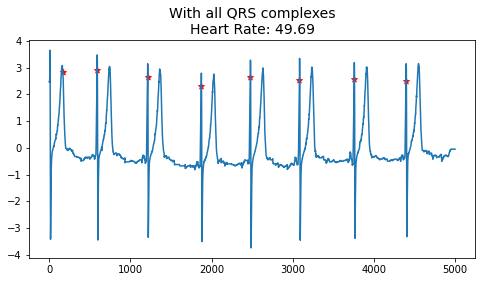

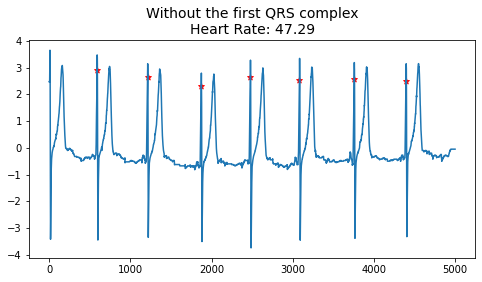

In [68]:
k, s = 11, 8
xqrs, rr, hr = ecg.qrs_rr_and_hr(X[k][:, s], fs, omit_first_rr=False)
ecg.plot_qrs(X[k][:, s], xqrs, f'With all QRS complexes\nHeart Rate: {round(hr, 2)}')
xqrs, rr, hr = ecg.qrs_rr_and_hr(X[k][:, s], fs, omit_first_rr=True)
ecg.plot_qrs(X[k][:, s], xqrs, f'Without the first QRS complex\nHeart Rate: {round(hr, 2)}')

It can also be the case that some of the QRS complexes are detected on the positive side of the signal with others been detected on the negative one. This does not affect the heart rate estimation, but it will be something to keep in mind when developping the new criteria.

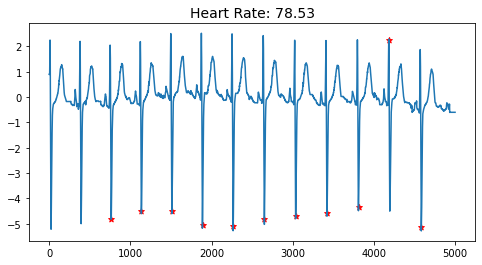

In [70]:
k, s = 12, 8
xqrs, rr, hr = ecg.qrs_rr_and_hr(X[k][:, s], fs, omit_first_rr=True)
ecg.plot_qrs(X[k][:, s], xqrs, f'Heart Rate: {round(hr, 2)}')

We are going to store the QRS complexes and heart rates for each record. We will store the heart rate of each of the 12 signals to further analyze if it changes significantly across signals.

In [71]:
files_in_path = os.listdir(path + 'qrs_hr/')

if 'hrs.csv' not in files_in_path:

    n = X.shape[0]

    for i in range(n):
        if f'qrs_{i+1}.json' not in files_in_path:
            qrs = dict()
            hrs = dict()
            # Calculate qrs and hr for each signal
            for s in range(12):
                xqrs, _, hr = ecg.qrs_rr_and_hr(X[i][:, s], fs, omit_first_rr=True)
                xqrs = [int(v) for v in xqrs]
                qrs[s] = xqrs
                hrs[s] = hr        
            # We save the values
            qrs_json = json.dumps(qrs, indent=4)
            hrs_json = json.dumps(hrs, indent=4)
            with open(path + 'qrs_hr/' + f'qrs_{i+1}.json', 'w') as outfile:
                outfile.write(qrs_json)
            with open(path + 'qrs_hr/' + f'hrs_{i+1}.json', 'w') as outfile:
                outfile.write(hrs_json)

We read the heart rates to analyze the distribution of these.

In [72]:
if 'hrs.csv' not in files_in_path:

    # Read the heart rate jsons
    hrs = dict()
    for i in range(n):    
        hr = open(path + 'qrs_hr/' + f'hrs_{i+1}.json')
        hr = json.load(hr)
        hrs[i] = list(hr.values())
    # Convert to pd.Series        
    hrs = pd.Series(hrs)        
    # Calculate mean within signals
    hrs_means = hrs.apply(np.mean)
    # Calculate if there are values that greatly differ
    hrs_out_of_desv = hrs.apply(ecg.hr_out_of_desv, desv=10)
    # Store them
    hrs.to_csv(path + 'qrs_hr/' + 'hrs.csv')
    hrs_means.to_csv(path + 'qrs_hr/' + 'hrs_means.csv')
    hrs_out_of_desv.to_csv(path + 'qrs_hr/' + 'hrs_out_of_desv.csv')
    
hrs = pd.read_csv(path + 'qrs_hr/' + 'hrs.csv', index_col=0)['0']
hrs_means = pd.read_csv(path + 'qrs_hr/' + 'hrs_means.csv', index_col=0)['0']
hrs_out_of_desv = pd.read_csv(path + 'qrs_hr/' + 'hrs_out_of_desv.csv', index_col=0)['0']

There are heart rates all the way from 40 to 180. However, most of them are contained between 50 and 100 beats per minute, which matches with what is generally expected.

<AxesSubplot:xlabel='0', ylabel='Density'>

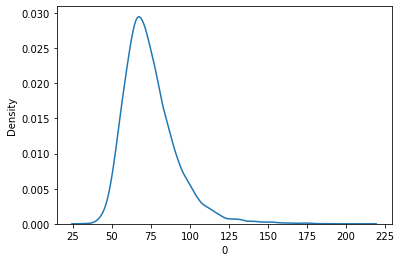

In [73]:
sns.kdeplot(hrs_means)

An initital natural thing to test is whether there is a difference in the heart rates of patients with and without an MI. As it would seem, there is no big difference, though patientes with MI have a slightly higher heart rate overall.

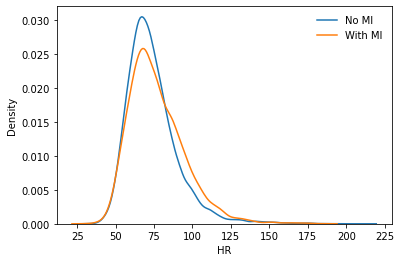

In [74]:
hr_by_mi = Y_mi.join(pd.DataFrame(hrs_means), how='inner')
hr_by_mi.columns = ['MI', 'HR']

sns.kdeplot(hr_by_mi[hr_by_mi['MI'] == 0]['HR'], label='No MI')
sns.kdeplot(hr_by_mi[hr_by_mi['MI'] == 1]['HR'], label='With MI')

plt.legend(frameon=False)

Most ECG do not seem to have a fluctuating heartbeat (as detected by the *wfdb* function). There only a few that have one or two, and many others that have more than 2 fluctuations.

<AxesSubplot:xlabel='0', ylabel='Count'>

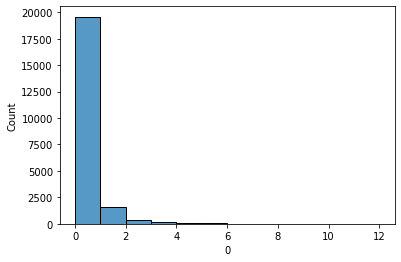

In [75]:
sns.histplot(hrs_out_of_desv, bins=np.max(hrs_out_of_desv))

We verified if those registgers with many fluctuations could be considered as outliers. However, it would not seem that to be the case, at least in the way we are trying to fliter out outliers.


For example, this registers had 10 deviations around the median. A quick look at it shows that it is by far no regular register (it has changes in amplitude, and it has considerably more dx than the regular ECG). However, it is not an outlier for us since it looks like median filter could easily correct the baseline drift, and there are no sudden unexplained spikes that the batch variance would detect.

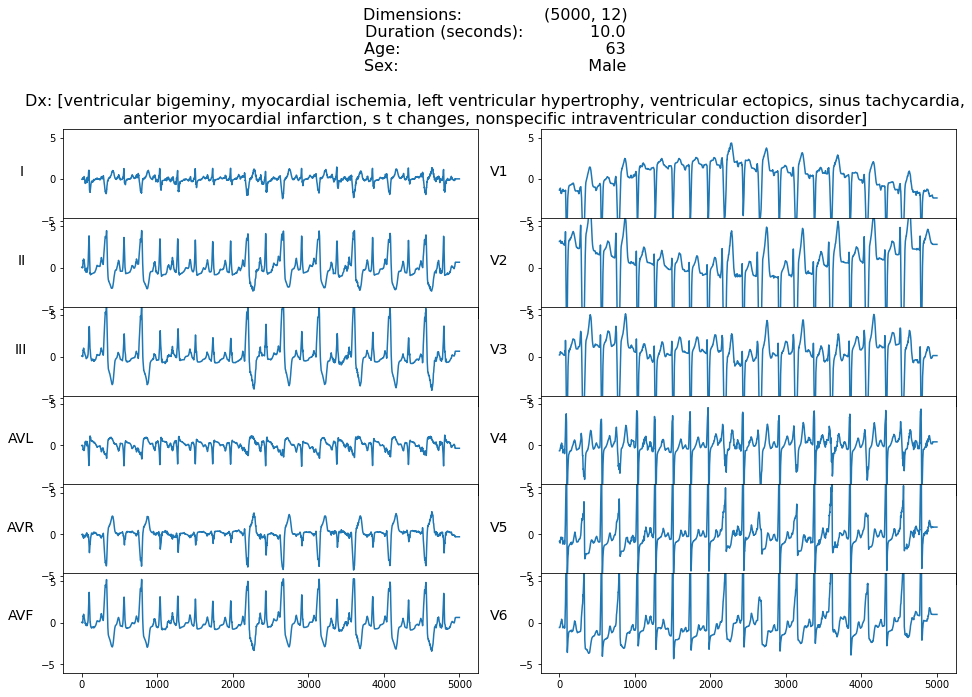

In [76]:
k = 737
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
ecg.plot_ecg(example[0], metadata=metadata)

The following example has 4 fluctuations. We can see that it is most likely due to the great amount of noise there is in the signals, particullarly from I, II, III, AVL, AVR and AVF. The function is not being able to adequatley detect the heart rate amongst so much noise. However, this is also not an outlier, since we can still let the neural network find the true pattern amongst all the noise.

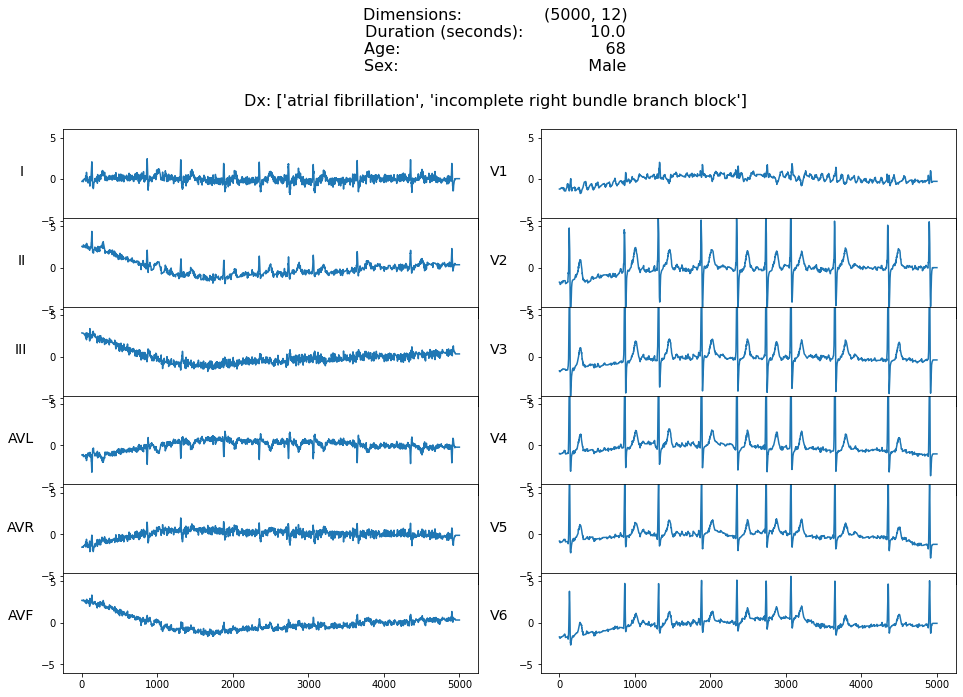

In [77]:
k = 1052            
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
ecg.plot_ecg(example[0], metadata=metadata)

An idea also is to use the heartrates in each signal as additional variables. This is still not implemented.

### Outlier detection : Second attempt

As we saw, the double median filter is not enough to discard outliers. One of the main issues is that it is very sensible to diagnoses that have a very high frequency (and could be labeled as false negativeS), and to registers that despite showing unexplained peaks, the second median cannot capture and treat such pattern (and could be labeled as false positives).

So, we would like a criteria that can try to minimize both false positives and negatives. What we noticed is that both of these can be in some way detected by observing at the amplitudes of the signals. The false negatives we saw earlier have very similar amplitudes accross the signal, while the fasle positive has a very high amplitude at the chunk in which the second median filter cannot detect the pattern.

Let's show them both graphically to grasp what we mean. For this, we will use the signals after having been applied one median filter, and we will make tha assumption thate we have already determined a correct way to calculate the average amplitude and its variance. This way we can create upper and lower bands around the signal.

**Example of a false negative:**

This was the example that had a very high vlaue for E. Note however, that most of its values seem to live around the gray dotted lines. These lines represent the average amplitude interval. The red dotted line is a variance augmented interval in which the signals can live. With this criteria, since none of the values of the signal live outside of the variance interval, then we could consider this as a non-outlier register.

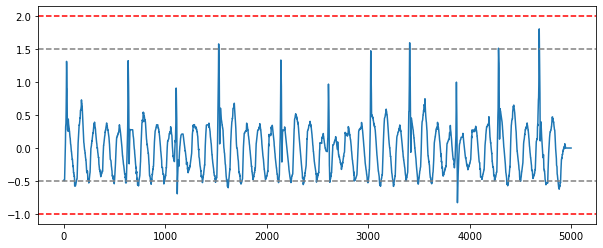

In [78]:
# Choose ecg and signal
s = 1
# k = np.argmax(E[:, s])
k = 705
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(1.5, color='gray', ls='--')
ax.axhline(2, color='red', ls='--')
ax.axhline(-0.5, color='gray', ls='--')
ax.axhline(-1, color='red', ls='--')

**Example of a false positive:**

On the other hand, this register could have passed the double median filter criteria. However, with the new criteria, we can see that several of its values live outside of the bands. For this reason, it would be considered an outlier.

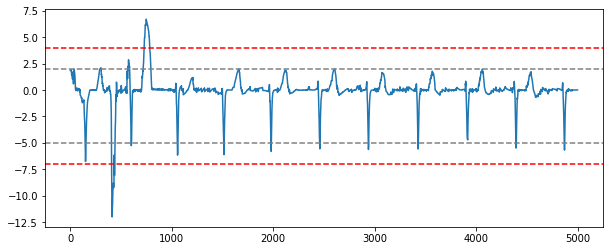

In [79]:
# Choose ecg and signal
s = 8
k = 3277
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(2, color='gray', ls='--')
ax.axhline(4, color='red', ls='--')
ax.axhline(-5, color='gray', ls='--')
ax.axhline(-7, color='red', ls='--')

### Brief Exploration of Previous Approaches

In previous work that has been removed from this notebook, we tried to approach the way to remove outliers in different manners. However, we will briefly include some of these just to show some of their limitations, and to perhaps consider using them again if certain things are changed about them.

A first idea was to simply use quantiles of the distribution. However, there is no unique combination of quantiles that generalize for all examples. It suffices to show how different the quantiles have to be in the previous examples to match the gray dotted lines that we calibrated. In this first example we need the 5% and 99.85% quantiles.

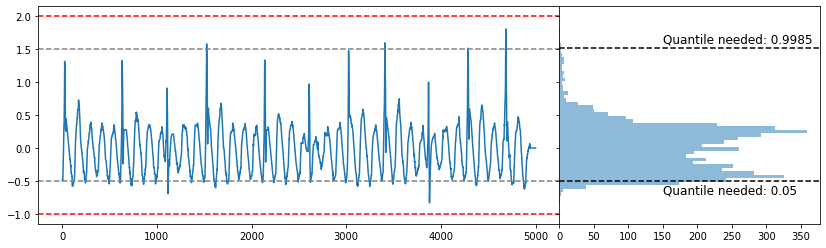

In [80]:
# Choose ecg and signal
s = 1
# k = np.argmax(E[:, s])
k = 705
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=True, 
                       gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(wspace=0)

ax[0].plot(x)
ax[1].hist(x.numpy(), bins=50, orientation='horizontal', alpha=0.5)

ax[0].axhline(1.5, color='gray', ls='--')
ax[0].axhline(2, color='red', ls='--')
ax[0].axhline(-0.5, color='gray', ls='--')
ax[0].axhline(-1, color='red', ls='--')
    
ax[1].text(150, 1.6, 'Quantile needed: 0.9985', size=12)
ax[1].text(150, -0.7, 'Quantile needed: 0.05', size=12)
ax[1].axhline(np.quantile(x.numpy(), 0.9985), color='black', ls='--')
ax[1].axhline(np.quantile(x.numpy(), 0.05), color='black', ls='--')

And in this one we need 1.6% and 98%. At least directly, it is clear that there are no unique pair of quantiles that achieves what we want. One possibility that was not explored was to take into account the sizes of the boxes from the histogram. Note how the first example has at most a box of around 350 points, while the second one has one of at most 2500. Perhaps we could find a function that way.

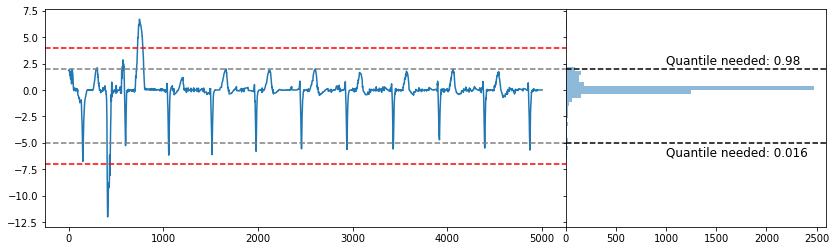

In [81]:
# Choose ecg and signal
s = 8
k = 3277
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=True, 
                       gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(wspace=0)

ax[0].plot(x)
ax[1].hist(x.numpy(), bins=50, orientation='horizontal', alpha=0.5)

ax[0].axhline(2, color='gray', ls='--')
ax[0].axhline(4, color='red', ls='--')
ax[0].axhline(-5, color='gray', ls='--')
ax[0].axhline(-7, color='red', ls='--')

ax[1].text(1000, 2.5, 'Quantile needed: 0.98', size=12)
ax[1].text(1000, -6.2, 'Quantile needed: 0.016', size=12)
ax[1].axhline(np.quantile(x.numpy(), 0.98), color='black', ls='--')
ax[1].axhline(np.quantile(x.numpy(), 0.016), color='black', ls='--')

After this, we tried looking at the distribution of the data in certain windows. The idea is to compare these in some way, perhaps through Kolmogorov–Smirnov tests and decide given the p-values if there were sections that greatly differed compared to the majority. The problem here is how to decide the length of the window to retrieve distributions. However, by using quantiles of quantiles within and across the distributions in each window, this could have been the method we stayed with.

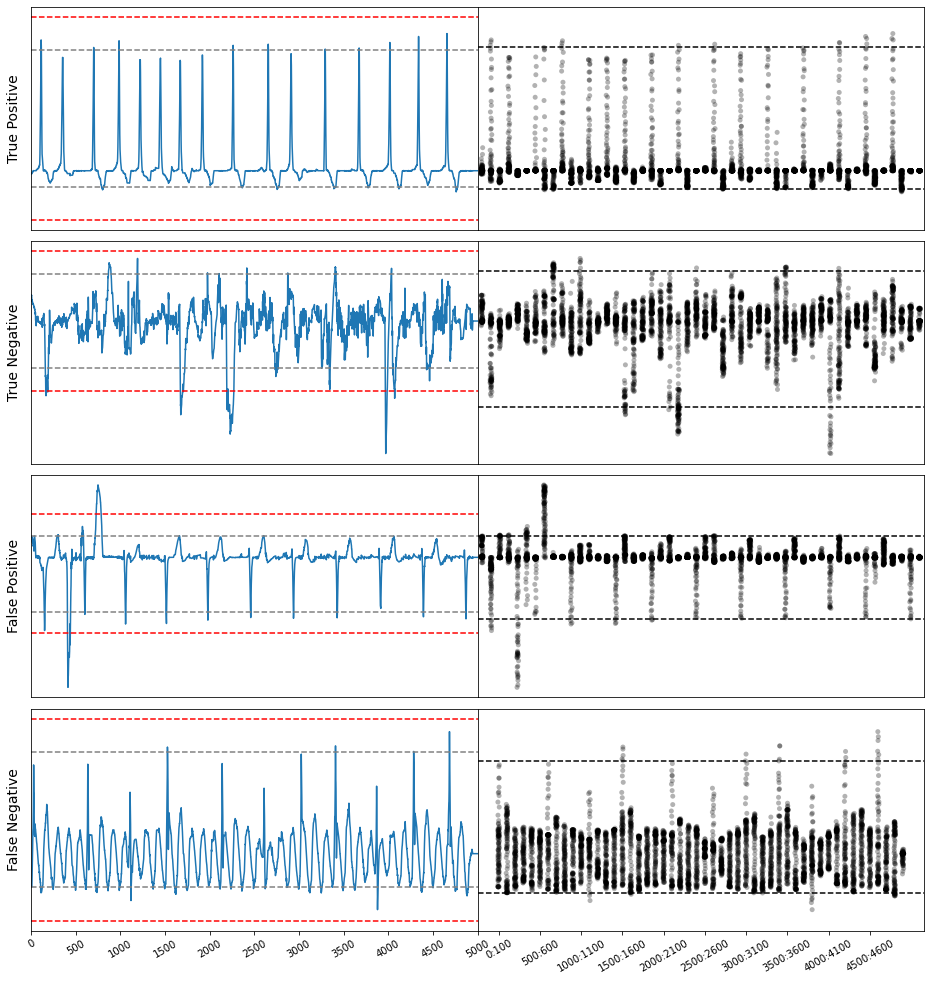

In [82]:
kk = [1232, 1251, 3277, 705]
ss = [1, 4, 8, 1]

kk = [1232, 1251, 3277, 705]
ss = [1, 4, 8, 1]

gts = [3.7, 1, 2, 1.5]
gls = [-0.5, -1, -5, -0.5]
rts = [4.7, 1.5, 4, 2]
rls = [-1.5, -1.5, -7, -1]

titles = ['True Positive', 'True Negative', 'False Positive', 'False Negative']

fig, ax = plt.subplots(4, 2, figsize=(16, 17), sharey='row')
ax = np.ravel(ax)
plt.subplots_adjust(wspace=0.0, hspace=0.05)

for i, k, s, gt, gl, rt, rl in zip(range(4), kk, ss, gts, gls, rts, rls):
    
    # Calculate median filter
    x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
    x = x.numpy()
    
    # Plot signal
    ax[2*i].plot(x)
    
    # Plot intervals
    ax[2*i].axhline(gt, color='gray', ls='--')
    ax[2*i].axhline(rt, color='red', ls='--')
    ax[2*i].axhline(gl, color='gray', ls='--')
    ax[2*i].axhline(rl, color='red', ls='--')
    ax[2*i].set_xlim(0, 5000)
    
    # Format plot
    ax[2*i].set_ylabel(f'{titles[i]}', fontsize=14, labelpad=10)
    ax[2*i].get_yaxis().set_ticks([])
    
    if 2*i == 6:
        plt.sca(ax[2*i])
        plt.xticks(rotation=30)
        plt.locator_params(nbins=10)
    else:
        plt.sca(ax[2*i])
        plt.xticks([])
    
    
    # Calculate window distributions
    n_pieces = 50
    x_df, q05_q05, q95_q95 = ecg.divide_x_in_pieces(x, n_pieces)
    
    # Plot distributions
    sns.stripplot(data=x_df, x='pieces', y='value', ax=ax[2*i+1], color='black', alpha=0.3)
    
    ax[2*i+1].axhline(q05_q05, color='black', ls='--')
    ax[2*i+1].axhline(q95_q95, color='black', ls='--')
    
    # Format plot
    ax[2*i+1].set_ylabel('')
    ax[2*i+1].set_xlabel('')
    ax[2*i+1].get_yaxis().set_ticks([])
    
    if 2*i+1 == 7:
        plt.sca(ax[2*i+1])
        plt.xticks(rotation=30)
        plt.locator_params(nbins=10)
    else:
        plt.sca(ax[2*i+1])
        plt.xticks([])

#### Important note:

Before developping the criteria, there are important things to be noted. First of all, the outliers we are trying to capture are those that show unexplainable noise. That is, noise being generated in 1 or 2 signals due to a brief disconnection of the nodes, due to muscular movements, due to voltage spikes, etc. The doctors who labelled this dataset, given their expertise, knew how to discern these noises and did not affect their diagnoses.

There are, however, patterns that are indeed related to diagnoses and might seem like sudden noise or relatively high changes in amplitudes. One of the most notable is the ventricular ectopics (we will dive deeper on it later on). For this reason, we have to be careful while developping the criteria so as to not missclassify registers that do not have unexplainable noise. For example, if an ECG has many signals that go outside of their variance amplitudes, it could actually mean that the whole register has a certain pattern going on, so we should not classify it as an outlier.

### Amplitude of the signals using the QRS

We read the QRS complexes.

In [83]:
files_in_path = os.listdir(path + 'qrs_hr/')

if 'qrs.json' not in files_in_path:

    # Read the heart rate jsons
    qrs = dict()
    n = X.shape[0]
    for i in range(n):    
        try:
            qr = open(path + 'qrs_hr/' + f'qrs_{i+1}.json')
            qr = json.load(qr)
            qrs[i] = list(qr.values())
        except FileNotFoundError:
            pass
        
    # Store in one single file
    with open(path + 'qrs_hr/' + 'qrs.json', 'w') as f:
        json.dump(qrs, f)
        
qrs = open(path + 'qrs_hr/' + 'qrs.json')
qrs = json.load(qrs)
qrs = {int(key) : value for key, value in qrs.items()}        

This is an example of what we are doing: Once we have located the QRS complexes, we then locate within non-overlapping intervals around these the maximum and minimum values.

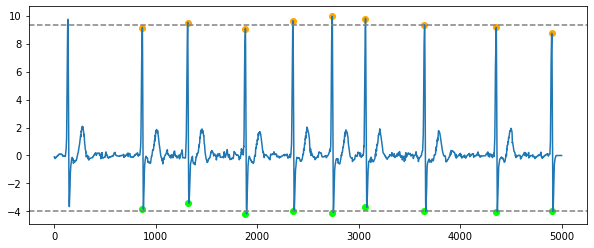

In [84]:
# Choose ecg and signal
s = 8
# k = np.argmax(E[:, s])
k = 1052
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
x = x.numpy()
qr = qrs[k]

max_points, min_points = ecg.calculate_median_peaks(x, qr, s, return_points=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.scatter(max_points.index, max_points.values, color='orange')
ax.scatter(min_points.index, min_points.values, color='lime')
ax.axhline(max_points.median(), color='gray', ls='--')
ax.axhline(min_points.median(), color='gray', ls='--')

**True positive:**

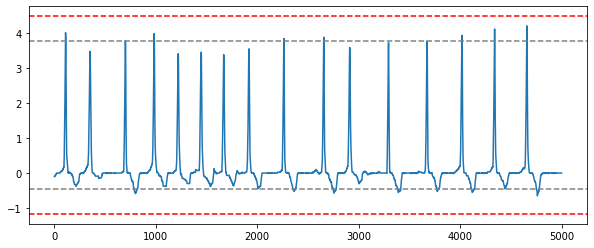

In [85]:
# Choose ecg and signal
s = 1
# k = np.argmax(E[:, s])
k = 1232
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
x = x.numpy()
qr = qrs[k]

max_median, min_median, var_f = ecg.calculate_median_peaks(x, qr, s)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(max_median, color='gray', ls='--')
ax.axhline(max_median + var_f, color='red', ls='--')
ax.axhline(min_median, color='gray', ls='--')
ax.axhline(min_median - var_f, color='red', ls='--')

**True negative:**

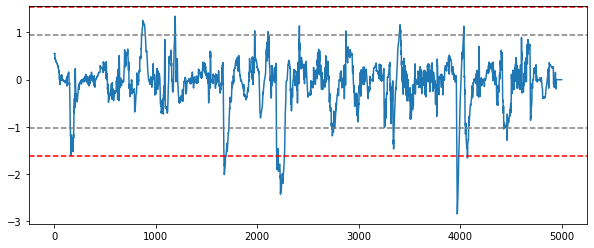

In [86]:
# Choose ecg and signal
s = 4
# k = np.argmax(E[:, s])
k = 1251
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
x = x.numpy()
qr = qrs[k]

max_median, min_median, var_f = ecg.calculate_median_peaks(x, qr, s)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(max_median, color='gray', ls='--')
ax.axhline(max_median + var_f, color='red', ls='--')
ax.axhline(min_median, color='gray', ls='--')
ax.axhline(min_median - var_f, color='red', ls='--')

**False negative:**

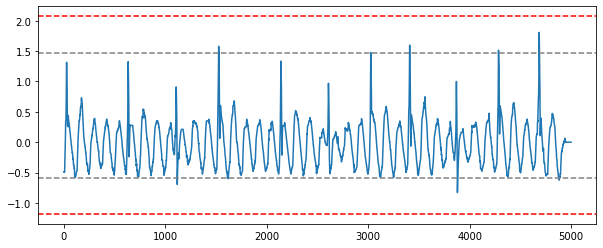

In [87]:
# Choose ecg and signal
s = 1
# k = np.argmax(E[:, s])
k = 705
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
x = x.numpy()
qr = qrs[k]

max_median, min_median, var_f = ecg.calculate_median_peaks(x, qr, s)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(max_median, color='gray', ls='--')
ax.axhline(max_median + var_f, color='red', ls='--')
ax.axhline(min_median, color='gray', ls='--')
ax.axhline(min_median - var_f, color='red', ls='--')

**False positive:**

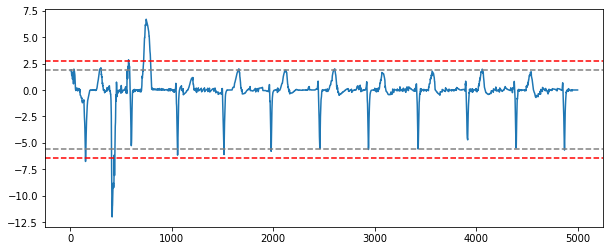

In [88]:
# Choose ecg and signal
s = 8
k = 3277
qr = qrs[k]
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
x = x.numpy()

max_median, min_median, var_f = ecg.calculate_median_peaks(x, qr, s)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(max_median, color='gray', ls='--')
ax.axhline(max_median + var_f, color='red', ls='--')
ax.axhline(min_median, color='gray', ls='--')
ax.axhline(min_median - var_f, color='red', ls='--')

**All combined**

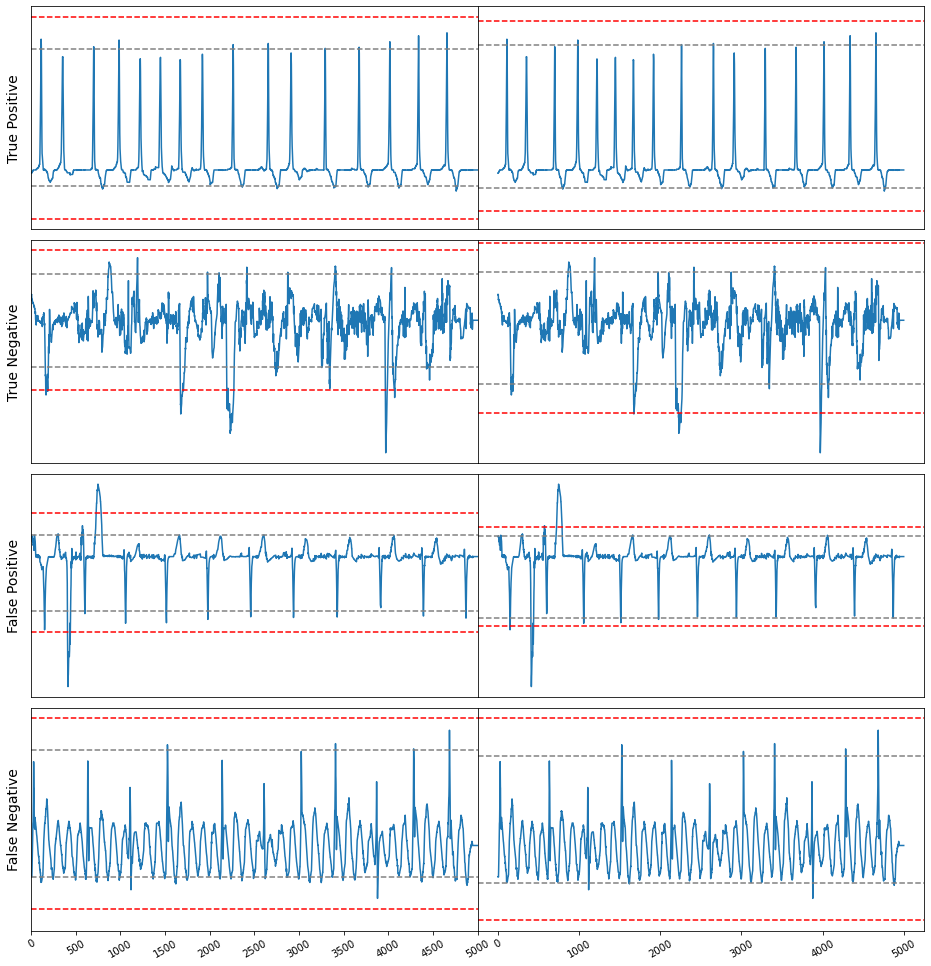

In [89]:
kk = [1232, 1251, 3277, 705]
ss = [1, 4, 8, 1]

kk = [1232, 1251, 3277, 705]
ss = [1, 4, 8, 1]

gts = [3.7, 1, 2, 1.5]
gls = [-0.5, -1, -5, -0.5]
rts = [4.7, 1.5, 4, 2]
rls = [-1.5, -1.5, -7, -1]

titles = ['True Positive', 'True Negative', 'False Positive', 'False Negative']

fig, ax = plt.subplots(4, 2, figsize=(16, 17), sharey='row')
ax = np.ravel(ax)
plt.subplots_adjust(wspace=0.0, hspace=0.05)

for i, k, s, gt, gl, rt, rl in zip(range(4), kk, ss, gts, gls, rts, rls):
    
    # Calculate median filter
    x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
    x = x.numpy()
    
    # Plot signal
    ax[2*i].plot(x)
    
    # Plot intervals
    ax[2*i].axhline(gt, color='gray', ls='--')
    ax[2*i].axhline(rt, color='red', ls='--')
    ax[2*i].axhline(gl, color='gray', ls='--')
    ax[2*i].axhline(rl, color='red', ls='--')
    ax[2*i].set_xlim(0, 5000)
    
    # Format plot
    ax[2*i].set_ylabel(f'{titles[i]}', fontsize=14, labelpad=10)
    ax[2*i].get_yaxis().set_ticks([])
    
    if 2*i == 6:
        plt.sca(ax[2*i])
        plt.xticks(rotation=30)
        plt.locator_params(nbins=10)
    else:
        plt.sca(ax[2*i])
        plt.xticks([])
    
    
    # Calculate window distributions
    n_pieces = 50
    x_df, q05_q05, q95_q95 = ecg.divide_x_in_pieces(x, n_pieces)
    
#     # Plot distributions
#     sns.stripplot(data=x_df, x='pieces', y='value', ax=ax[2*i+1], color='black', alpha=0.3)
    
#     ax[2*i+1].axhline(q05_q05, color='black', ls='--')
#     ax[2*i+1].axhline(q95_q95, color='black', ls='--')

    max_median, min_median, var_f = ecg.calculate_median_peaks(x, qr, s)
    ax[2*i+1].plot(x)
    ax[2*i+1].axhline(max_median, color='gray', ls='--')
    ax[2*i+1].axhline(max_median + var_f, color='red', ls='--')
    ax[2*i+1].axhline(min_median, color='gray', ls='--')
    ax[2*i+1].axhline(min_median - var_f, color='red', ls='--')
    
    # Format plot
    ax[2*i+1].set_ylabel('')
    ax[2*i+1].set_xlabel('')
    ax[2*i+1].get_yaxis().set_ticks([])
    
    if 2*i+1 == 7:
        plt.sca(ax[2*i+1])
        plt.xticks(rotation=30)
        plt.locator_params(nbins=10)
    else:
        plt.sca(ax[2*i+1])
        plt.xticks([])

#### Ventricular Ectopics

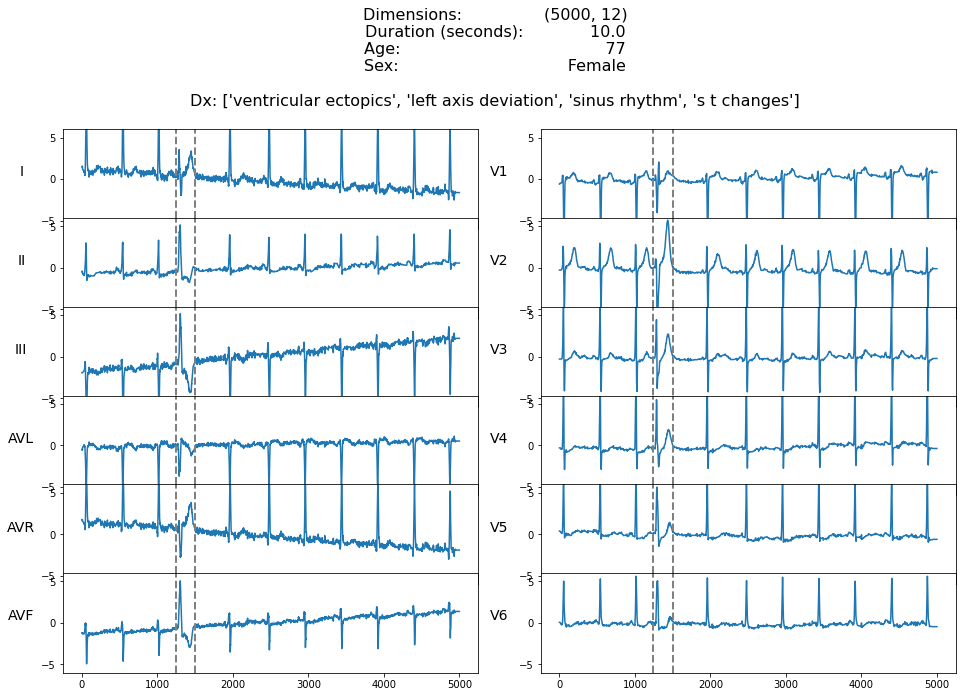

In [90]:
ve_index = labels[labels['Diagnostic Description'] == 'ventricular ectopics'].index[0]
ve = Y_snomed.copy()[Y_snomed[str(ve_index)] == 1]

k = ve.index[0]

example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
ecg.plot_ecg(example[0], metadata=metadata, vlines=[1245, 1500])

#### Calculate the amount of times the signal went beyond the thresholds

For each register, we calculae the amount of times that each of the signals went beyond the thresholds defined earlier.
For each, we will also calculate the amount of simoultaneous times many signals went above the thresholds, in order to account for ventricular ectopics.

In [91]:
files_in_path = os.listdir(path + 'qrs_hr/')

n = X.shape[0]
for i in range(n):
    if f'beyond_{i+1}.json' not in files_in_path:
        beyonds = dict()
        x = ecg.tf_median_filter_ecg(X[i], 200, 'reflect')
        x = x.numpy()
        beyonds_sum = ecg.values_beyond_median_peaks(x, qrs[i])
        was_1_or_2 = len(beyonds_sum[(beyonds_sum > 0) & (beyonds_sum < 3)])
        was_over_4 = len(beyonds_sum[beyonds_sum > 4])
        beyonds['beyond_sum'] = list(beyonds_sum)
        beyonds['was_1_or_2'] = [was_1_or_2]
        beyonds['was_over_4'] = [was_over_4]
        beyonds_json = json.dumps(str(beyonds), indent=4)
        
        with open(path + 'qrs_hr/' + f'beyond_{i+1}.json', 'w') as outfile:
            outfile.write(beyonds_json)                        

In [92]:
files_in_path = os.listdir(path + 'qrs_hr/')

if f'beyond.csv' not in files_in_path:
    # Read the heart rate jsons
    beyond_sum = dict()
    was_1_or_2 = dict()
    was_over_4 = dict()
    n = X.shape[0]
    for i in range(n):    
        try:
            beyond = open(path + 'qrs_hr/' + f'beyond_{i+1}.json')
            beyond = json.load(beyond)
            beyond = eval(beyond)
            beyond_sum[i] = beyond['beyond_sum']
            was_1_or_2[i] = beyond['was_1_or_2'][0]
            was_over_4[i] = beyond['was_over_4'][0]
        except FileNotFoundError:
            pass

    beyond_sum = pd.DataFrame(beyond_sum).transpose()
    was_1_or_2 = pd.Series(was_1_or_2)
    was_over_4 = pd.Series(was_over_4)
    
    beyond_sum.to_csv(path + 'qrs_hr/beyond.csv')
    was_1_or_2.to_csv(path + 'qrs_hr/was_1_or_2.csv')
    was_over_4.to_csv(path + 'qrs_hr/was_over_4.csv')
    
beyond_sum = pd.read_csv(path + 'qrs_hr/beyond.csv', index_col=0)
was_1_or_2 = pd.read_csv(path + 'qrs_hr/was_1_or_2.csv', index_col=0)['0']
was_over_4 = pd.read_csv(path + 'qrs_hr/was_over_4.csv', index_col=0)['0']

The following are the distributions for the value counts of registers in which there were 1 or 2 lone signals that went beyond the threshold, as well as the ones for which 5 or more joint signals went over the threshold together.

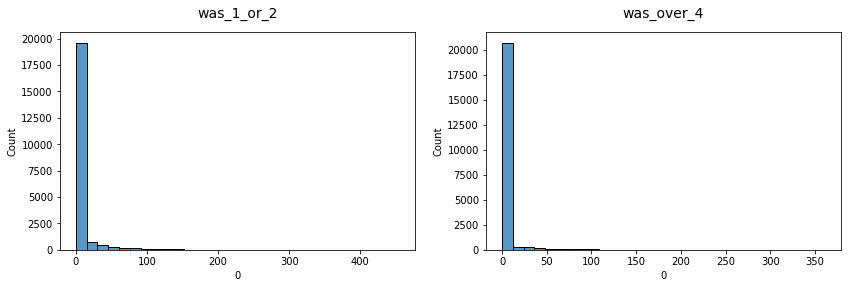

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(was_1_or_2, bins=30, ax=ax[0])
sns.histplot(was_over_4, bins=30, ax=ax[1])
ax[0].set_title('was_1_or_2', fontsize=14, y=1.04)
ax[1].set_title('was_over_4', fontsize=14, y=1.04);

We reviewed several examples in order to determine an adequate criteria to determine what is an outlier. The following rules are the ones that seem to work best.

In [94]:
files_in_path = os.listdir(path + 'qrs_hr/')
first_rule = 5
second_rule = 25

if f'beyond_either_{first_rule}_{second_rule}.csv' not in files_in_path:

    beyond_either = pd.DataFrame([was_1_or_2, was_over_4])
    beyond_either = beyond_either.transpose()
    beyond_either.columns = ['was_1_or_2', 'was_over_4']

    for i, row in beyond_either.iterrows():
        if row['was_over_4'] >= first_rule:
            beyond_either.loc[row.name, 'outlier'] = False
        elif row['was_1_or_2'] >= second_rule:
            beyond_either.loc[row.name, 'outlier'] = True
        else:
            beyond_either.loc[row.name, 'outlier'] = False

    beyond_either['outlier'] = beyond_either['outlier'].astype(int)
    beyond_either.to_csv(path + 'qrs_hr/' + f'beyond_either_{first_rule}_{second_rule}.csv')
    
beyond_either = pd.read_csv(path + 'qrs_hr/' + f'beyond_either_{first_rule}_{second_rule}.csv', index_col=0)

We will be removing the following amount of registers from the dataset.

In [95]:
print('# of outliers: ', beyond_either['outlier'].sum())
print('% of outliers: ', round(100 * beyond_either['outlier'].sum() / len(X), 2), '%')

# of outliers:  827
% of outliers:  3.79 %


It would be idea to not lose MI registers, but at least we lost close to the same proportion as in the whole dataset.

In [96]:
mi_outlier = Y_mi.join(beyond_either[['outlier']])
mi_cf_outlier = confusion_matrix(mi_outlier['MI'], mi_outlier['outlier'])
print('# of MI outliers: ', mi_cf_outlier[1, 1])
print('% of MI outliers: ', round(100 * (mi_cf_outlier[1, 1] / Y_mi.sum()).iloc[0], 2), '%')

# of MI outliers:  238
% of MI outliers:  4.34 %


Here is an example of an outlier.

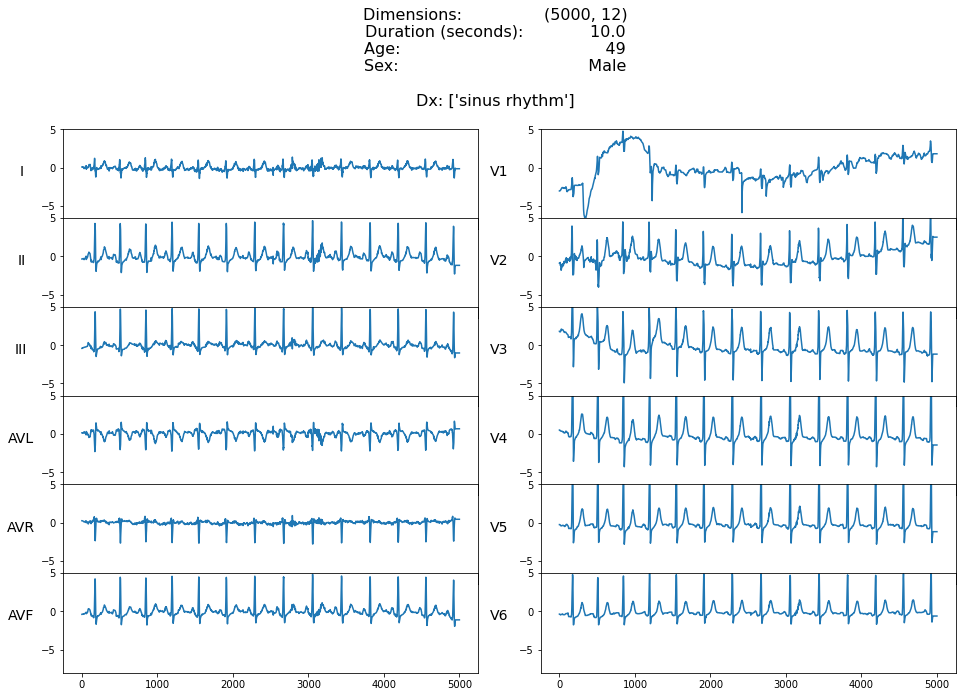

In [97]:
outliers = beyond_either.copy().query('outlier == 1')
k = outliers.index[0]

example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
ecg.plot_ecg(example[0], metadata=metadata, ylim=(-8, 5)
#              vlines=[1245, 1500]
            )

Text(0.5, 1.04, 'Signal after applying a median filter')

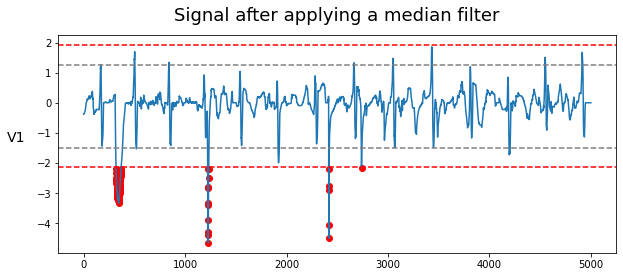

In [98]:
# Choose ecg and signal
s = 6
qr = qrs[k]
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
x = x.numpy()

max_median, min_median, var_f = ecg.calculate_median_peaks(x, qr, s)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(max_median, color='gray', ls='--')
ax.axhline(max_median + var_f, color='red', ls='--')
ax.axhline(min_median, color='gray', ls='--')
ax.axhline(min_median - var_f, color='red', ls='--')

for i, xx, p in zip(range(len(x)), x, (x > max_median + var_f) | (x < min_median - var_f)):
    if p:
        ax.scatter(i, xx, color='red')
        
ax.set_ylabel('V1', fontsize=14, rotation=0, labelpad=20)
ax.set_title('Signal after applying a median filter', fontsize=18, y=1.04)

Here is an example of an outlier.

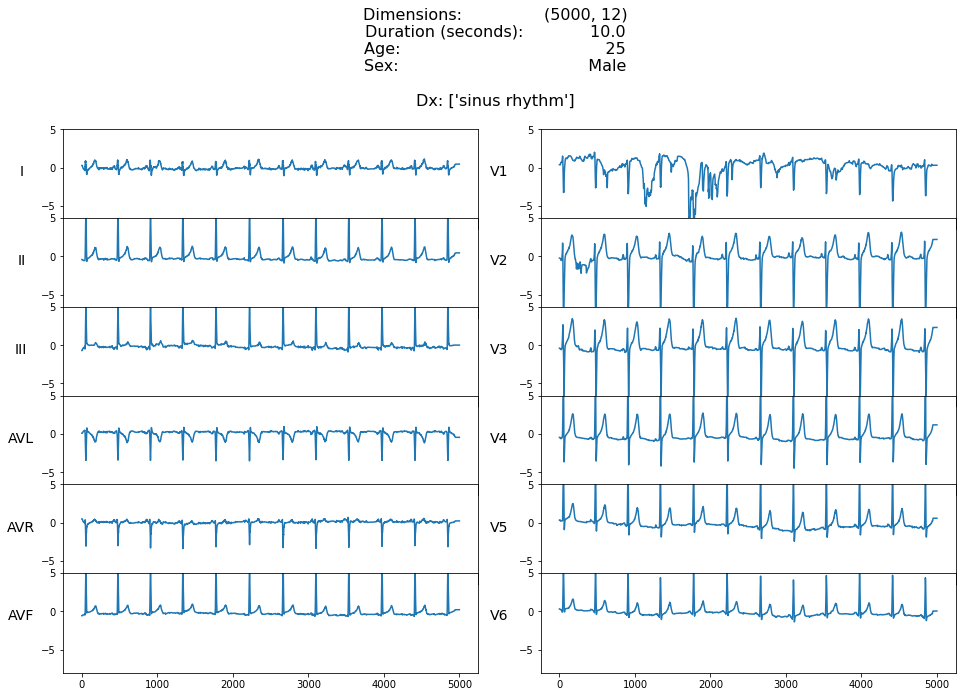

In [99]:
outliers = beyond_either.copy().query('outlier == 1')
k = outliers.index[10]

example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
ecg.plot_ecg(example[0], metadata=metadata, ylim=(-8, 5)
#              vlines=[1245, 1500]
            )

Text(0.5, 1.04, 'Signal after applying a median filter')

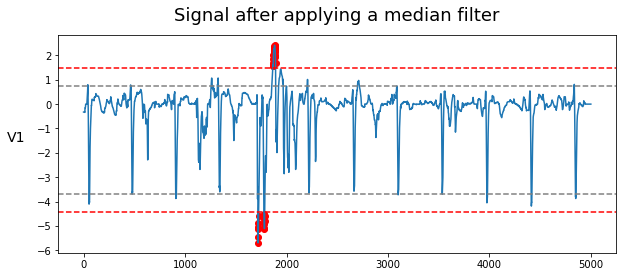

In [100]:
# Choose ecg and signal
s = 6
qr = qrs[k]
# Apply median filtering once
x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
x = x.numpy()

max_median, min_median, var_f = ecg.calculate_median_peaks(x, qr, s)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x)
ax.axhline(max_median, color='gray', ls='--')
ax.axhline(max_median + var_f, color='red', ls='--')
ax.axhline(min_median, color='gray', ls='--')
ax.axhline(min_median - var_f, color='red', ls='--')

for i, xx, p in zip(range(len(x)), x, (x > max_median + var_f) | (x < min_median - var_f)):
    if p:
        ax.scatter(i, xx, color='red')
        
ax.set_ylabel('V1', fontsize=14, rotation=0, labelpad=20)
ax.set_title('Signal after applying a median filter', fontsize=18, y=1.04)

With this criteria, let's revisit the examples we presented earlier. We can see that the true positive and true negative are in line with what the median peks criteria says. However, now we can keep the register that was a false negative while also reject the register that was a false positive!

In [101]:
index = ['true positive', 'true negative', 'false negative', 'false positive']
ss = [1, 4, 1, 8]
kk = [1232, 1251, 705, 3277]

examples = pd.DataFrame(index=index, columns=['E', 'E Criteria', 'was_1_or_2', 'was_over_4', 'Median Peak Criteria'])

for idx, s, k in zip(index, ss, kk):

    # Apply median filtering once
    x, med = ecg.tf_median_filter(X[k][:, s], 200, 'reflect', return_mf=True)
    # Apply median filtering twice
    x_2, med_2 = ecg.tf_median_filter(x.numpy(), 200, 'reflect', return_mf=True)
    # Calculate the value of E
    e_out = tf.math.reduce_sum((x - x_2) ** 2 / tf.math.reduce_variance(x))
    examples.loc[idx, 'E'] = e_out.numpy()
    # Suppose we use a cutoff of 50
    examples.loc[idx, 'E Criteria'] =  'outlier' if e_out.numpy() > 50 else 'regular'
    # Add the threshold columns
    examples.loc[idx, 'was_1_or_2'] = beyond_either.loc[k, 'was_1_or_2']
    examples.loc[idx, 'was_over_4'] = beyond_either.loc[k, 'was_over_4']
    # Median peak criteria
    examples.loc[idx, 'Median Peak Criteria'] = 'outlier' if bool(beyond_either.loc[k, 'outlier']) else 'regular'

examples    

E E Criteria was_1_or_2 was_over_4  \
true positive     0.779641    regular         10          0   
true negative    272.69131    outlier         93          0   
false negative  475.444592    outlier          6          0   
false positive    5.095161    regular        140          0   

               Median Peak Criteria  
true positive               regular  
true negative               outlier  
false negative              regular  
false positive              outlier

### Correction of High Frequency Noise

The correction of high frequency noise was not explored in this notebook. We add these last 2 cells as a view of what is the idea in order to further correct this kind of noise.

Text(0, 0.5, 'I')

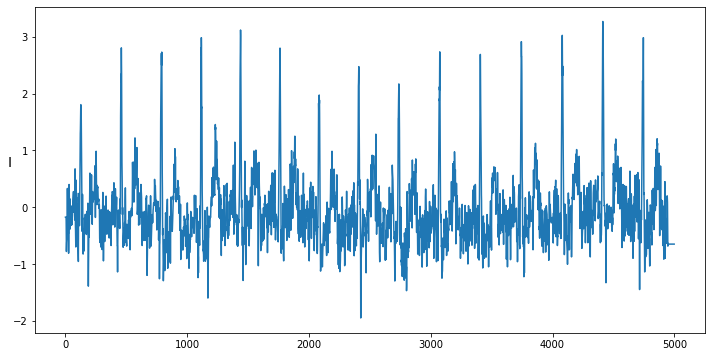

In [102]:
k, s = 13002, 0
x = X[k, : , s]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x)
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)

Text(0, 0.5, 'I')

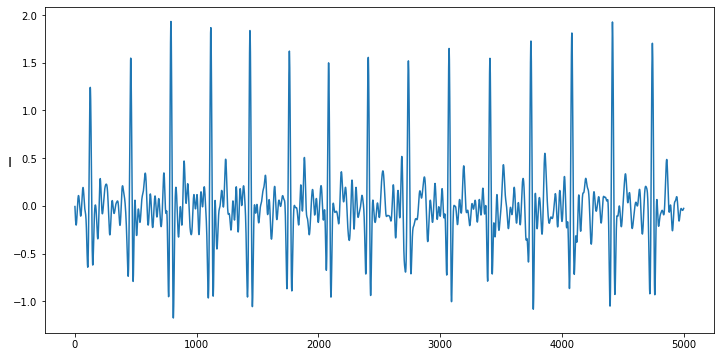

In [106]:
from biosppy.signals.tools import filter_signal

filter_bandwidth = [3, 20]
fs = 500
order = int(0.3 * fs)

signal, _, _ = filter_signal(signal=x, ftype='FIR', band='bandpass',
                             order=order, frequency=filter_bandwidth, 
                             sampling_rate=fs)
# filter_signal(x, )

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(signal)
ax.set_ylabel(ecg.signals[s], rotation=0, fontsize=14)